In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc, average_precision_score
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import chi2_contingency
import scorecardpy as sc
from IPython.display import display
import scipy.stats as st
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
#! pip install monotonic-binning
from monotonic_binning.monotonic_woe_binning import Binning
#! pip install sidetable
import sidetable
from matplotlib.backends.backend_pdf import PdfPages
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string
import matplotlib.lines as mlines
import gc
import sas7bdat 
import pyreadstat
from numpy import linalg


In [2]:
####################################
## CHANGE FILENAMES IN THIS BLOCK ##
####################################

file_type = 'sas' # 'sas' or 'csv'

# declare the development and OOT filenames
dev_file = 'development_sample'
oot_file = 'validation_sample'

# declare the target column
# ensure that 'bad' is 1 and 'good' is 0
target_column = 'default_12M'

In [3]:
# read in data and assign good/bad flag
if dev_file is not None:
    if file_type == 'csv':
        file_name = "{}.csv".format(dev_file)
        dev_df = pd.read_csv(file_name)
        dev_df['gb_flag'] = dev_df[target_column]
        dev_df_gb = dev_df[dev_df['gb_flag'].isin([0,1])]
        dev_df_gb.drop(columns=[target_column], inplace=True)
    elif file_type == 'sas':
        file_name = "{}.sas7bdat".format(dev_file)
        dev_df, meta = pyreadstat.read_sas7bdat(file_name)
        dev_df['gb_flag'] = dev_df[target_column]
        dev_df_gb = dev_df[dev_df['gb_flag'].isin([0,1])]
        dev_df_gb.drop(columns=[target_column], inplace=True)
    else:
        raise Exception('Incorrect file type declared')
else:
    # Handle the case when no filename is provided.
    dev_df = pd.DataFrame()

if oot_file is not None:
    if file_type == 'csv':
        file_name2 = "{}.csv".format(oot_file)
        oot_df = pd.read_csv(file_name2)
        oot_df['gb_flag'] = oot_df[target_column]
        oot_df_gb = oot_df[oot_df['gb_flag'].isin([0,1])]
        oot_df.drop(columns=[target_column], inplace=True)
    elif file_type == 'sas':
        file_name = "{}.sas7bdat".format(oot_file)
        oot_df, meta = pyreadstat.read_sas7bdat(file_name)
        oot_df['gb_flag'] = oot_df[target_column]
        oot_df_gb = oot_df[dev_df['gb_flag'].isin([0,1])]
        oot_df_gb.drop(columns=[target_column], inplace=True)
    else:
        raise Exception('Incorrect file type declared')
else:
    # Handle the case when no filename is provided.
    oot_df = pd.DataFrame()

In [4]:
dev_df_gb.head()

AgreementNumber  arrearscycle2 type        LoanPurpose  InitialTerm  Score1 SubPopulationIndicator1  Score2 SubPopulationIndicator2  Score3  e1_a_01sp  e1_a_02sp  e1_a_03sp  e1_a_04sp  e1_a_05sp  e1_a_06sp  e1_a_08sp  e1_a_09sp  e1_a_10sp  e1_a_11sp  e1_b_01sp  e1_b_02sp e1_b_03sp  e1_b_04sp e1_b_05sp  e1_b_06sp  \
0          28555.0            0.0  EML            Holiday         36.0   878.0                       O   693.0                       D  -999.0        0.0        0.0        0.0        0.0       18.0        5.0        3.0        0.0       18.0        5.0        3.0      119.0         0        3.0         0       73.0   
1          35499.0            0.0  EML  DebtConsolidation         36.0   837.0                       O   422.0                       A  -999.0        0.0        0.0        0.0        0.0        0.0        0.0        2.0        0.0        0.0        0.0        1.0       12.0         N        0.0         0      363.0   
2          35499.0            0.0  EML  DebtConsolidation         36.0   837.0                       O   422.0                       A  -999.0        0.0        0.0        0.0        0.0        0.0        0.0        2.0        0.0        0.0        0.0        1.0       12.0         N        0.0         0      365.0   
3          37480.0            0.0  EML              Other         36.0   752.0                       O   451.0                       D  -999.0        0.0        0.0        0.0        1.0        1.0       65.0        0.0        1.0        1.0       65.0        1.0        4.0         N        0.0         0      232.0   
4          37597.0            0.0  EML            Vehicle         36.0   828.0                       O   450.0                       A  -999.0        0.0        0.0        0.0        0.0        0.0        0.0        1.0        0.0        0.0        0.0        0.0        0.0         0        3.0         0      174.0   

  e1_b_07sp e1_b_08sp  e1_b_09sp  e1_b_10sp  e1_b_11sp  e1_b_12sp  e1_b_13sp e1_c_01sp  e1_c_02sp  e1_c_03sp  e1_c_04sp  e1_c_05sp  e1_c_06sp  e1_d_01sp  e1_d_03sp  e1_d_04sp  e1_e_01sp  e1_e_02sp  e2_g_01spa  e2_g_02spa  e2_g_03spa  e2_g_04spa  e2_g_05spa  e2_g_06spa  e2_g_08spa  e2_g_09spa  e2_g_10spa  e2_g_11spa  \
0         U         U        9.0      195.0      212.0        0.0        0.0         0        2.0       25.0        0.0        0.0        0.0        1.0        0.0        1.0        1.0        1.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0   
1         U         U        9.0      375.0        0.0        0.0        0.0         0        2.0       47.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0         0.0         0.0         0.0         0.0         0.0         0.0         2.0         0.0         0.0         0.0   
2         U         0        9.0      376.0        0.0        0.0        0.0         0        2.0       46.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0         0.0         0.0         0.0         0.0         0.0         0.0         3.0         0.0         0.0         0.0   
3         U         U        9.0      236.0        0.0        0.0        0.0         0        2.0       36.0        0.0        0.0        0.0        0.0        0.0        0.0        1.0        1.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0   
4         0         0        9.0      176.0        0.0        0.0        0.0         0        2.0       21.0        0.0        0.0        0.0        0.0        0.0        0.0        1.0        2.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0   

   e2_h_01spa  e2_h_02spa e2_h_03spa  e2_h_04spa e2_h_05spa  e2_h_06spa e2_h_07spa e2_h_08spa  e2_h_09spa  e2_h_10spa  e2_h_11spa  ...  hc_f_06  hc_p_01 hc_p_02 

In [5]:
dev_df_gb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57307 entries, 0 to 57306
Columns: 459 entries, AgreementNumber to gb_flag
dtypes: float64(366), object(93)
memory usage: 200.7+ MB


In [6]:
dev_df_gb.drop(['ea4_s_04sp','e4_r_02sp','statusname','nd_dobsp', 'ea4_s_06sp', 'ea4_s_08sp', 'sp_k_80','AgreementNumber','LoanPurpose','InitialTerm','SubPopulationIndicator1','Advance','LN','Full'],inplace=True,axis=1)
oot_df_gb.drop(['ea4_s_04sp','e4_r_02sp','statusname','nd_dobsp', 'ea4_s_06sp', 'ea4_s_08sp', 'sp_k_80','AgreementNumber','LoanPurpose','InitialTerm','SubPopulationIndicator1','Advance','LN','Full'],inplace=True,axis=1)


In [7]:
dev_df_gb.describe()

arrearscycle2        Score1        Score2   Score3     e1_a_01sp     e1_a_02sp     e1_a_03sp     e1_a_04sp     e1_a_05sp     e1_a_06sp     e1_a_08sp     e1_a_09sp     e1_a_10sp     e1_a_11sp     e1_b_01sp     e1_b_02sp     e1_b_04sp     e1_b_06sp     e1_b_09sp     e1_b_10sp     e1_b_11sp     e1_b_12sp  \
count        57307.0  57307.000000  57307.000000  57307.0  57307.000000  57307.000000  57307.000000  57307.000000  57307.000000  57307.000000  57307.000000  57307.000000  57307.000000  57307.000000  57307.000000  57307.000000  57307.000000  57307.000000  57307.000000  57307.000000  57307.000000  57307.000000   
mean             0.0    853.225208    651.406565   -999.0      0.465650     72.318844     12.983824      1.370094     29.050465     19.114506      1.085661      1.624548     39.405710     17.837926      0.782906     19.263127     45.260125     77.948436      8.176244    141.555395     16.527806      0.075401   
std              0.0    218.965856    214.951571      0.0      0.894099    248.438559     22.512795      2.153725     89.838302     23.844186      1.384236      2.311183    124.048734     23.173668      0.949683     39.251807     65.261580     91.674914      1.509703    128.275553     52.677484      0.325972   
min              0.0   -998.000000   -998.000000   -999.0      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      1.000000      1.000000      0.000000      0.000000   
25%              0.0    814.500000    523.000000   -999.0      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      7.000000     19.000000      8.000000     57.000000      0.000000      0.000000   
50%              0.0    866.000000    671.000000   -999.0      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      1.000000      1.000000      1.000000      1.000000      1.000000      1.000000     27.000000     47.000000      9.000000    100.000000      0.000000      0.000000   
75%              0.0    899.000000    786.000000   -999.0      1.000000      6.000000     24.000000      2.000000     17.000000     39.000000      2.000000      2.000000     21.000000     36.000000      1.000000     28.000000     52.000000    102.000000      9.000000    182.000000      0.000000      0.000000   
max              0.0   1757.000000   1107.000000   -999.0      9.000000    999.000000     99.000000      9.000000    999.000000     72.000000      9.000000      9.000000    999.000000     80.000000      9.000000    945.000000    999.000000    999.000000      9.000000    999.000000    850.000000      9.000000   

          e1_b_13sp     e1_c_02sp     e1_c_03sp     e1_c_04sp     e1_c_05sp     e1_c_06sp     e1_d_01sp     e1_d_03sp     e1_d_04sp     e1_e_01sp     e1_e_02sp    e2_g_01spa    e2_g_02spa    e2_g_03spa    e2_g_04spa    e2_g_05spa    e2_g_06spa    e2_g_08spa    e2_g_09spa    e2_g_10spa    e2_g_11spa    e2_h_01spa  \
count  57307.000000  57307.000000  57307.000000  57307.000000  57307.000000  57307.000000  57307.000000  57307.000000  57307.000000  57307.000000  57307.000000  57307.000000  57307.000000  57307.000000  57307.000000  57307.000000  57307.000000  57307.000000  57307.000000  57307.000000  57307.000000  57307.000000   
mean       0.412777      1.924407     44.456838      0.055386      0.035214      0.181234      0.038809      0.062418      0.052786      0.606470      1.152983      0.193240     26.125482      4.827054      0.568657      9.929799      6.721832      0.367547      0.661752     12.764008      6.354826      0.127087   
std        1.525952      0.409433     25.770815      0.294086      0.236562      0.768627      0.248111      0.296495      0.289635      0.976758      1.454578      0.635616    152.171730     14.861170      1.552031     46.488161     16.4

In [8]:
dev_df_gb.stb.freq(['gb_flag'], style = True)

In [9]:
oot_df_gb.stb.freq(['gb_flag'], style = True)

In [10]:
# missing check
# Set the option to display all rows
pd.set_option('display.max_rows', None)
missing_summary = dev_df_gb.stb.missing()
print(missing_summary[missing_summary['missing'] > 0])

Empty DataFrame
Columns: [missing, total, percent]
Index: []


In [11]:
# missing check
# Set the option to display all rows
pd.set_option('display.max_rows', None)
missing_summary = oot_df_gb.stb.missing()
print(missing_summary[missing_summary['missing'] > 0])

Empty DataFrame
Columns: [missing, total, percent]
Index: []


In [10]:
train, test = sc.split_df(dev_df_gb, 'gb_flag', ratio = 0.7, seed = 999).values()
# train = dev_df_gb.copy()
# test = oot_df_gb.copy()

train['gb_flag'] = train['gb_flag'].astype(int)
test['gb_flag'] = test['gb_flag'].astype(int)

In [11]:
print('Train sample shape: ',train.shape)
print('Test sample shape: ',test.shape)

Train sample shape:  (40115, 445)
Test sample shape:  (17192, 445)


In [12]:
train.stb.freq(['gb_flag'], style = True)

In [13]:
test.stb.freq(['gb_flag'], style = True)

In [14]:
# This function, plot_woe, creates a dual-axis plot to visualise the Weight of Evidence (WOE) or Bad Rate metric for different bins of a categorical variable.
# It takes four arguments:
#   - train_bins: a dataframe containing binning information for the training dataset.
#   - test_bins: a dataframe containing binning information for the testing dataset.
#   - var_name: the name of the variable being analyzed.
#   - metric: either 'woe' or 'badprob' to specify which metric to plot (default is 'woe').

def plot_woe(train_bins, test_bins, var_name, metric='woe'):
    assert metric in ['woe', 'badprob'], "Invalid metric. Choose either 'woe' or 'badprob'"
    # Select the binning information for var_name
    train_data = train_bins[var_name]
    test_data = test_bins[var_name]

    fig, ax1 = plt.subplots(figsize=(7,4))

    # Condition to change ylabel
    if metric == 'woe':
        ax1.set_ylabel('Weights of Evidence', fontsize=10)
    elif metric == 'badprob':
        ax1.set_ylabel('Bad rate', fontsize=6)

    # Set bin ranges as x-tick labels
    x_ticks = train_data['bin'].values
    
    # Plot the metric values
    ax1.set_title(f'Distribution and for :: {var_name}', fontsize=10)
    ax1.set_xlabel('Bins', fontsize=10)        
    ax1.plot(x_ticks, train_data[metric], color='b', linestyle='--', marker='x')
    ax1.plot(x_ticks, test_data[metric], color='g', linestyle='--', marker='o')
    ax1.tick_params(axis='y')

    plt.xticks(rotation = 45, fontsize=8)

    # Create the second axis
    ax2 = ax1.twinx()
    
    # Plot the distribution of observations
    ax2.set_ylabel('Observation %', fontsize=10)
    ax2.bar(train_data['bin'], train_data['count_distr'], color='red', alpha=0.3)
    ax2.bar(test_data['bin'], test_data['count_distr'], color='grey', alpha=0.3)
    ax2.tick_params(axis='y')

    train_line = mlines.Line2D([], [], color='blue', linestyle='--', marker='x', label=f'Train {metric}')
    test_line = mlines.Line2D([], [], color='green', linestyle='-', marker='o', label=f'Test {metric}')
    train_bar = mlines.Line2D([], [], color='red', marker='s', linestyle='None', label='Train Observation %')
    test_bar = mlines.Line2D([], [], color='grey', marker='s', linestyle='None', label='Test Observation %')

    ax1.legend([train_line, test_line, train_bar, test_bar], [f'Train {metric}', f'Test {metric}', 'Train Observation %', 'Test Observation %'], loc='lower left', bbox_to_anchor=(1,1))

    fig.tight_layout()
    plt.show()

In [19]:
# This function, char_bin, is used for binning a categorical variable based on its relationship with a binary target variable.
# It takes two arguments:
#   - Y: The binary target variable.
#   - X: The categorical variable to be characterized and binned.

def char_bin(Y, X):
    # print('Char classing variable: ',X.name)    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["LOWER"] = df2.sum().Y.index
    d3["UPPER"] = d3["LOWER"]
    d3["BAD"] = df2.sum().Y
    d3["GOOD"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'LOWER':np.nan},index=[0])
        d4["UPPER"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["BAD"] = justmiss.sum().Y
        d4["GOOD"] = justmiss.count().Y - justmiss.sum().Y
        # d3 = d3.append(d4,ignore_index=True)
        d3 = pd.concat([d3,d4],ignore_index=True)
    
    # print(d3[~d3['COUNT'].apply(lambda x: isinstance(x, (int, np.int64, float, np.float64)))])
    d3["COUNT_RATE"] = d3.COUNT/d3.sum().COUNT
    d3["BAD_RATE"] = d3.BAD/d3.COUNT
    d3["GOOD_RATE"] = d3.GOOD/d3.COUNT
    d3["DIST_BAD"] = d3.BAD/d3.sum().BAD
    d3["DIST_GOOD"] = d3.GOOD/d3.sum().GOOD
    d3["WOE"] = np.log(d3.DIST_GOOD/d3.DIST_BAD)
    d3["IV"] = (d3.DIST_GOOD-d3.DIST_BAD)*np.log(d3.DIST_GOOD/d3.DIST_BAD)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','LOWER', 'UPPER', 'COUNT', 'COUNT_RATE', 'BAD', 'BAD_RATE', 'GOOD', 'GOOD_RATE', 'DIST_BAD','DIST_GOOD','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    d3 = d3.sort_values(['VAR_NAME', 'LOWER'])
    
    return(d3)

In [16]:
def mono_bin(Y, X, force_bin = 3, minbin=0.05, optimise = False, print_detail = False, special_values = [-999998,-999997,-999996,-999995,-3,-2,-1,0]):
    """
    Bin a numeric variable based on its relationship with a binary target variable.
    
    Parameters:
        Y (pd.Series): The binary target variable.
        X (pd.Series): The numeric variable to be binned.
        force_bin (int): The minimum number of bins to create (default is 3).
        special_values (list): A list of special values to separate into their own bins (default is [-999998,-999997,-999996,-999995,-3,-2,-1,0]).
    
    Returns:
        pd.DataFrame: A DataFrame containing binning information.
    """
    if print_detail: 
        print('Num classing variable: ',X.name)   
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]

    # Separate the special values into their own DataFrame
    special = notmiss[notmiss.X.isin(special_values)]
    notmiss = notmiss[~notmiss.X.isin(special_values)]

    n = max(force_bin, int(len(notmiss) // (len(notmiss) * minbin)))

    # if 'dumb' fine classing
    if not optimise:
        if notmiss.X.nunique() < 5:
            bins = notmiss.X.unique().tolist()
            bins = np.append(bins, np.inf)
            bins = sorted(bins)
        else:
            bins = np.percentile(notmiss.X, np.linspace(0, 100, n+1))
            # bins = np.append(bins, np.inf)
            bins = sorted(bins)

        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins), duplicates='drop',include_lowest=True,right=False)})
        d2 = d1.groupby('Bucket', as_index=True)
        # adjust bins with less than 50 counts
        while True:
            bins_modified = False
            # Get the count of 'Y' in the last bucket
            last_bucket_count = d2.count().iloc[-1]['Y']
            if last_bucket_count < 50 and len(d2) > 1:
                # Merge the last bucket with the one before it
                bins = np.delete(bins, -2)  # Remove the 2nd last bin value
                d1['Bucket'] = pd.cut(d1['X'], bins, duplicates='drop', include_lowest=True, right=False)
                d2 = d1.groupby('Bucket', as_index=True)
                bins_modified = True
            
            if not bins_modified:
                break

    # if 'smart' fine classing
    if optimise:
        r = 0
        max_iv = 0 # initialise max IV as 0
        optimal_d2 = None
        
        while np.abs(r) < 1:
            try:
                d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n, duplicates='drop')})
                # d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, n, duplicates='drop')})
                d2 = d1.groupby('Bucket', as_index=True)
                # Check for 0 volume buckets
                if (d2.count().Y > 0).all():
                    r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
                    bad_rate_bin = d2.sum().Y / d2.sum().Y.sum()
                    good_rate_bin = (d2.count().Y - d2.sum().Y) / (d2.count().Y.sum() - d2.sum().Y.sum())
                    woe_bin = np.log(bad_rate_bin / good_rate_bin)
                    iv_bin = (bad_rate_bin - good_rate_bin) * woe_bin
                    total_iv = iv_bin.sum()
                    if total_iv > max_iv:   # check if current IV is > max IV so far
                        max_iv = total_iv   # update the max IV
                        optimal_d2 = d2     # save the current bins as optimal bins
                n = n-1                 # reduce the number of bins
            except Exception as e:
                n = n-1

    if 'optimal_d2' not in locals():
        optimal_d2 = d2

    d3 = pd.DataFrame({},index=[])
    d3["LOWER"] = d2.min().X
    d3["UPPER"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["BAD"] = d2.sum().Y
    d3["GOOD"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'LOWER':np.nan},index=[0])
        d4["UPPER"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["BAD"] = justmiss.sum().Y
        d4["GOOD"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    if not special.empty:
        for idx, value in enumerate(special_values):
            d5 = pd.DataFrame({'LOWER':value},index=[0])
            d5["UPPER"] = value
            d5["COUNT"] = special[special.X == value].count().Y
            d5["BAD"] = special[special.X == value].sum().Y
            d5["GOOD"] = special[special.X == value].count().Y - special[special.X == value].sum().Y
            d3 = pd.concat([d3, d5], ignore_index=True)
    
    d3["COUNT_RATE"] = d3.COUNT/d3.sum().COUNT
    d3["BAD_RATE"] = d3.BAD/d3.COUNT
    d3["GOOD_RATE"] = d3.GOOD/d3.COUNT
    d3["DIST_BAD"] = d3.BAD/d3.sum().BAD
    d3["DIST_GOOD"] = d3.GOOD/d3.sum().GOOD
    d3["WOE"] = np.log(d3.DIST_GOOD/d3.DIST_BAD)
    d3["IV"] = (d3.DIST_GOOD-d3.DIST_BAD)*np.log(d3.DIST_GOOD/d3.DIST_BAD)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','LOWER', 'UPPER', 'COUNT', 'COUNT_RATE', 'BAD', 'BAD_RATE', 'GOOD', 'GOOD_RATE', 'DIST_BAD','DIST_GOOD','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.sort_values(['VAR_NAME', 'LOWER'])
    
    return(d3)

In [17]:
def data_vars(df1, target, optimise):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i],optimise=optimise)
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = pd.concat([iv_df, conv], ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv) 

In [18]:
mono_bin(train.gb_flag,train.sp_g_38,optimise=False,special_values=[-2,-1])

VAR_NAME  LOWER  UPPER  COUNT  COUNT_RATE  BAD  BAD_RATE  GOOD  GOOD_RATE  DIST_BAD  DIST_GOOD       WOE        IV
0       VAR    1.0   28.0   1984    0.049459  616  0.310484  1368   0.689516  0.064794   0.044696 -0.371342  0.099801
1       VAR   29.0   34.0   1974    0.049210  595  0.301418  1379   0.698582  0.062585   0.045055 -0.328648  0.099801
2       VAR   35.0   38.0   1924    0.047963  589  0.306133  1335   0.693867  0.061954   0.043617 -0.350940  0.099801
3       VAR   39.0   41.0   1787    0.044548  584  0.326805  1203   0.673195  0.061428   0.039305 -0.446528  0.099801
4       VAR   42.0   44.0   2076    0.051753  639  0.307803  1437   0.692197  0.067214   0.046950 -0.358792  0.099801
5       VAR   45.0   47.0   2277    0.056763  663  0.291173  1614   0.708827  0.069738   0.052733 -0.279505  0.099801
6       VAR   48.0   49.0   1512    0.037693  375  0.248016  1137   0.751984  0.039445   0.037148 -0.059978  0.099801
7       VAR   50.0   52.0   2416    0.060228  646  0.267384  1770   0.732616  0.067950   0.057830 -0.161265  0.099801
8       VAR   53.0   54.0   1635    0.040759  441  0.269725  1194   0.730275  0.046387   0.039011 -0.173181  0.099801
9       VAR   55.0   57.0   2453    0.061151  556  0.226661  1897   0.773339  0.058483   0.061979  0.058060  0.099801
10      VAR   58.0   59.0   1587    0.039562  344  0.216761  1243   0.783239  0.036184   0.040612  0.115441  0.099801
11      VAR   60.0   62.0   2323    0.057910  490  0.210934  1833   0.789066  0.051541   0.059888  0.150103  0.099801
12      VAR   63.0   64.0   1503    0.037468  340  0.226214  1163   0.773786  0.035763   0.037998  0.060612  0.099801
13      VAR   65.0   67.0   2063    0.051428  466  0.225885  1597   0.774115  0.049017   0.052178  0.062496  0.099801
14      VAR   68.0   71.0   2283    0.056913  468  0.204993  1815   0.795007  0.049227   0.059300  0.186172  0.099801
15      VAR   72.0   76.0   2234    0.055691  406  0.181737  1828   0.818263  0.042705   0.059725  0.335424  0.099801
16      VAR   77.0   81.0   1964    0.048960  358  0.182281  1606   0.817719  0.037656   0.052472  0.331769  0.099801
17      VAR   82.0   88.0   1897    0.047290  319  0.168160  1578   0.831840  0.033554   0.051557  0.429522  0.099801
18      VAR   89.0  103.0   2202    0.054894  332  0.150772  1870   0.849228  0.034922   0.061097  0.559358  0.099801
19      VAR  104.0  289.0   2020    0.050356  280  0.138614  1740   0.861386  0.029452   0.056850  0.657650  0.099801

In [20]:
final_iv, IV = data_vars(train,train.gb_flag, optimise=False)

In [22]:
# there is an error in sc.weobin which calculates WoE as (%bad / %good)
# Loop through the dictionary keys and update
def update_bins(bins_dict):
    for key in bins_dict:
        bins_dict[key]['woe'] *= -1
        bins_dict[key]['variable'] = key
        # bins_dict[key]['count_distr'] *= 100

In [23]:
breaks_list = final_iv.groupby('VAR_NAME')['LOWER'].apply(lambda x: sorted(list(x))).to_dict()

train_bins = sc.woebin(train,y='gb_flag',breaks_list=breaks_list)
test_bins = sc.woebin(test,y='gb_flag',breaks_list=breaks_list)
# oot_bins = sc.woebin(oot_df_gb,y='gb_flag',breaks_list=breaks_list)

# Now apply this function to all datasets
update_bins(train_bins)
update_bins(test_bins)
# update_bins(oot_bins)

# create an empty list to hold all the data
all_data = []

# iterate over the dictionary
for var_name, df in train_bins.items():
    # add a blank row at the end
    blank_row = pd.DataFrame(pd.Series(dtype='object')).transpose()
    # append the data and blank row to all_data
    all_data.extend([df, blank_row])

# concatenate all the dataframes
final_df = pd.concat(all_data, ignore_index=True)

# write to excel
final_df.to_excel('fine_classing1.xlsx', index=False)

del final_df
gc.collect()

[INFO] creating woe binning ...
Binning on 40115 rows and 406 columns in 00:00:51
[INFO] creating woe binning ...
Binning on 17192 rows and 406 columns in 00:00:26


0

In [24]:
# converting into woe transformed values
train_woe_all = sc.woebin_ply(train, train_bins).drop('gb_flag', axis=1)

[INFO] converting into woe values ...
Woe transformating on 40115 rows and 405 columns in 00:00:54


In [25]:
def get_sorted_iv(data,select=50):
    # Create a list to hold the tuples of variable name and total_iv
    iv_list = []

    # Loop over the dictionary
    for var_name, df in data.items():
        # Append a tuple of variable name and total_iv to the list
        iv_list.append((var_name, df['total_iv'].values[0]))

    # Sort the list in descending order of total_iv
    iv_list.sort(key=lambda x: x[1], reverse=True)

    return iv_list[:select]

# Call the function and print the result
sorted_iv_list = get_sorted_iv(train_bins,select=20)
for item in sorted_iv_list:
    print(item)

('nd_sp_ciisp', 0.23701406006980186)
('Score2', 0.22376672766878966)
('e5_s_05_2_all', 0.22376672766878966)
('sp_f3_34', 0.20029236174744844)
('Score1', 0.1897709801424125)
('e5_s_05_1_all', 0.1897709801424125)
('sp_f1_30', 0.18281634456962498)
('clu_npr_l1m', 0.17416611554503164)
('sp_f1_29', 0.1530287458131526)
('sp_f3_35', 0.15279773506296213)
('e1_b_07sp', 0.09984051983257392)
('sp_g_38', 0.0998365204827919)
('e1_b_08sp', 0.09266155723712341)
('sp_a_08', 0.09070068023867564)
('nd_hac_04sp', 0.08050141719550052)
('nd_hac_02sp', 0.07949670257211369)
('e4_q_17sp', 0.07854762867895629)
('e1_b_12sp', 0.07793411947827374)
('clu_cli_l6m', 0.07618244733681852)
('sp_f1_31', 0.07307951527420341)


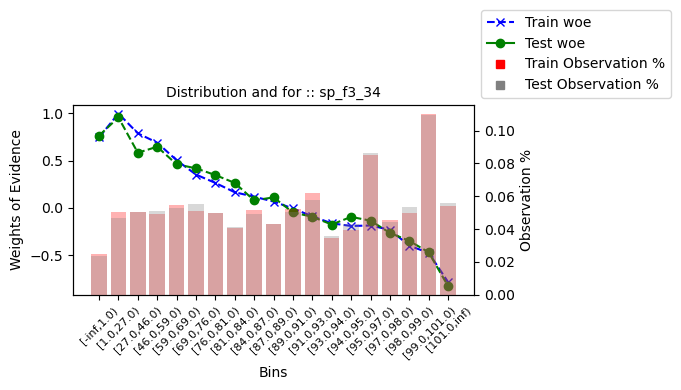

variable           bin  count  count_distr  good   bad   badprob       woe    bin_iv  total_iv breaks  is_special_values
0   sp_f3_34    [-inf,1.0)    987     0.024604   860   127  0.128673  0.743512  0.010958  0.200292    1.0              False
1   sp_f3_34    [1.0,27.0)   2032     0.050654  1823   209  0.102854  0.996671  0.037451  0.200292   27.0              False
2   sp_f3_34   [27.0,46.0)   2019     0.050330  1769   250  0.123824  0.787476  0.024805  0.200292   46.0              False
3   sp_f3_34   [46.0,59.0)   1978     0.049308  1711   267  0.134985  0.688352  0.019147  0.200292   59.0              False
4   sp_f3_34   [59.0,69.0)   2195     0.054718  1848   347  0.158087  0.503301  0.012017  0.200292   69.0              False
5   sp_f3_34   [69.0,76.0)   2046     0.051003  1679   367  0.179374  0.351359  0.005710  0.200292   76.0              False
6   sp_f3_34   [76.0,81.0)   2008     0.050056  1621   387  0.192729  0.263141  0.003224  0.200292   81.0              False
7   sp_f3_34   [81.0,84.0)   1635     0.040758  1294   341  0.208563  0.164378  0.001053  0.200292   84.0              False
8   sp_f3_34   [84.0,87.0)   2061     0.051377  1615   446  0.216400  0.117538  0.000688  0.200292   87.0              False
9   sp_f3_34   [87.0,89.0)   1736     0.043276  1345   391  0.225230  0.066209  0.000186  0.200292   89.0              False
10  sp_f3_34   [89.0,91.0)   2094     0.052200  1595   499  0.238300 -0.007210  0.000003  0.200292   91.0              False
11  sp_f3_34   [91.0,93.0)   2488     0.062022  1857   631  0.253617 -0.089821  0.000512  0.200292   93.0              False
12  sp_f3_34   [93.0,94.0)   1381     0.034426  1011   370  0.267922 -0.164041  0.000966  0.200292   94.0              False
13  sp_f3_34   [94.0,95.0)   1591     0.039661  1156   435  0.273413 -0.191858  0.001533  0.200292   95.0              False
14  sp_f3_34   [95.0,97.0)   3428     0.085454  2494   934  0.272462 -0.187066  0.003136  0.200292   97.0              False
15  sp_f3_34   [97.0,98.0)   1833     0.045694  1317   516  0.281506 -0.232228  0.002612  0.200292   98.0              False
16  sp_f3_34   [98.0,99.0)   2008     0.050056  1372   636  0.316733 -0.400407  0.008838  0.200292   99.0              False
17  sp_f3_34  [99.0,101.0)   4420     0.110183  2947  1473  0.333258 -0.475746  0.027906  0.200292  101.0              False
18  sp_f3_34   [101.0,inf)   2175     0.054219  1294   881  0.405057 -0.784797  0.039548  0.200292    inf              False

In [26]:
plot_woe(train_bins, test_bins, 'sp_f3_34', metric='woe')
train_bins['sp_f3_34']

[INFO] creating woe binning ...
[INFO] creating woe binning ...


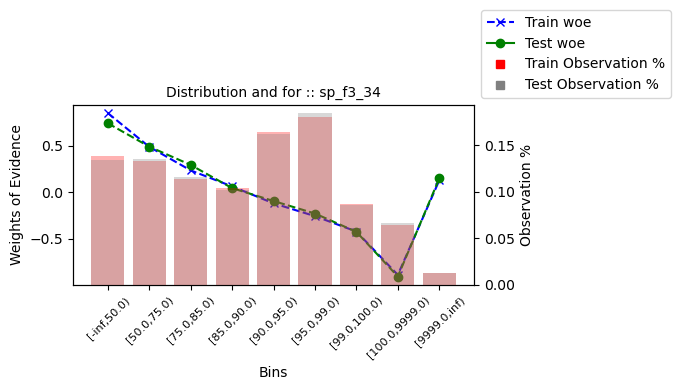

variable             bin  count  count_distr  good   bad   badprob       woe    bin_iv  total_iv  breaks  is_special_values
0  sp_f3_34     [-inf,50.0)   5565     0.138726  4913   652  0.117161  0.850362  0.078176  0.206962    50.0              False
1  sp_f3_34     [50.0,75.0)   5353     0.133441  4495   858  0.160284  0.486884  0.027561  0.206962    75.0              False
2  sp_f3_34     [75.0,85.0)   4579     0.114147  3675   904  0.197423  0.233246  0.005826  0.206962    85.0              False
3  sp_f3_34     [85.0,90.0)   4160     0.103702  3219   941  0.226202  0.060650  0.000375  0.206962    90.0              False
4  sp_f3_34     [90.0,95.0)   6594     0.164377  4882  1712  0.259630 -0.121340  0.002497  0.206962    95.0              False
5  sp_f3_34     [95.0,99.0)   7269     0.181204  5183  2086  0.286972 -0.259097  0.012976  0.206962    99.0              False
6  sp_f3_34    [99.0,100.0)   3503     0.087324  2375  1128  0.322010 -0.424682  0.017435  0.206962   100.0              False
7  sp_f3_34  [100.0,9999.0)   2599     0.064789  1479  1120  0.430935 -0.891196  0.061927  0.206962  9999.0              False
8  sp_f3_34    [9999.0,inf)    493     0.012290   387   106  0.215010  0.125753  0.000188  0.206962     inf              False

In [27]:
# Define the features and target variable
features = ['sp_f3_34']
target = 'gb_flag'
dt = train[features + [target]]
dt1 = test[features + [target]]

# original binning breaks list
breaks_list_new = {
      'sp_f3_34':[0.0,50,75,85,90.0,95.0,99.0,100,9999]
    }

# Recalculate your bins and replot
train_bins_new = sc.woebin(dt, y=target, breaks_list=breaks_list_new)
test_bins_new = sc.woebin(dt1, y=target, breaks_list=breaks_list_new)

update_bins(train_bins_new)
update_bins(test_bins_new)

plot_woe(train_bins_new, test_bins_new, 'sp_f3_34')
train_bins_new['sp_f3_34']

In [28]:
# converting into woe transformed values
train_woe = sc.woebin_ply(dt, train_bins_new)
test_woe = sc.woebin_ply(dt1, test_bins_new)

y_train_woe = train_woe.loc[:,target]
X_train_woe = train_woe.loc[:,train_woe.columns != target]
y_test_woe = test_woe.loc[:,target]
X_test_woe = test_woe.loc[:,train_woe.columns != target]

# create logistic regression instance
# fit the model to the train data
# generate predicted values
from sklearn.linear_model import LogisticRegression
# lr = LogisticRegression(penalty='l1', C=0.9, solver='saga', n_jobs=-1)
lr = LogisticRegression()
lr.fit(X_train_woe, y_train_woe)

train_pred = lr.predict_proba(X_train_woe)[:,1]
test_pred = lr.predict_proba(X_test_woe)[:,1]

fpr_train, tpr_train, thresholds_train = roc_curve(y_train_woe, train_pred)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test_woe, test_pred)

auc_train = roc_auc_score(y_train_woe, train_pred)
auc_test = roc_auc_score(y_test_woe, test_pred)

gini_train = (2 * auc_train - 1)*100
gini_test = (2 * auc_test - 1)*100

print('---- Gini comparison ----')
print('Gini: %.2f' % gini_train)
print('Test Gini: %.2f' % gini_test)
print('Gini var: %.2f' % (100*abs(gini_train - gini_test) / gini_train))
print('---- End ----')

[INFO] converting into woe values ...
[INFO] converting into woe values ...
---- Gini comparison ----
Gini: 24.84
Test Gini: 24.14
Gini var: 2.79
---- End ----


In [29]:
X_train_woe[:].corr()

sp_f3_34_woe
sp_f3_34_woe           1.0

In [30]:
# run a different model type to get nicer outputs - results are the same
logit_model = sm.Logit(y_train_woe, sm.add_constant(X_train_woe))
sm_result = logit_model.fit()

# Get the p-values for each predictor variable
sm_result.summary2()

Optimization terminated successfully.
         Current function value: 0.529306
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.033     
Dependent Variable: gb_flag          AIC:              42470.2316
Date:               2023-12-21 14:49 BIC:              42487.4306
No. Observations:   40115            Log-Likelihood:   -21233.   
Df Model:           1                LL-Null:          -21967.   
Df Residuals:       40113            LLR p-value:      0.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
const            -1.1692   0.0120 -97.0735 0.0000 -1.1928 -1.1456
sp_f3_34_woe     -1.0000   0.0270 -37.0646 0.0000 -1.0529 -0.9471
=================================================================

"""

In [21]:
def calculate_miv(print_details='no'):
    miv = {}

    # Assuming you already have 'train_woe_all', 'train_woe', and 'target' DataFrames loaded
    
    # df of woe variables not yet stepped in
    train_woe_rem = train_woe_all[train_woe_all.columns.difference(train_woe.columns)]
    train_woe_new = pd.merge(train_woe, train_woe_rem, left_index=True, right_index=True)

    for new_var in train_woe_rem.columns:
        try:
            # Create an extended set of features by adding the new variable
            if print_details.lower() == 'yes':
                print(f'Adding: {new_var}')
                
            X_extended = train_woe_new[train_woe.columns.tolist() + [new_var]]

            predictors = sm.add_constant(X_extended.drop(target, axis=1))

            # Calculate the IV of the extended model
            iv_extended = sc.iv(X_extended, x=new_var, y=target)
            iv_extended_sum = iv_extended['info_value'].sum()
            
            if print_details.lower() == 'yes':
                print('IV:', iv_extended_sum)
            
            # Calculate the VIF values for each predictor variable
            vif = pd.DataFrame()
            vif['Variable'] = predictors.columns
            vif['VIF'] = [variance_inflation_factor(predictors.values, i) for i in range(predictors.shape[1])]

            # Replace NaN values with an epsilon value
            epsilon = 1e-6
            vif.fillna(value=epsilon, inplace=True)
            
            # Filter VIF values by predictor variable name
            vif_new_var = vif.loc[vif['Variable'] == new_var, 'VIF'].iloc[0]
            
            if print_details.lower() == 'yes':
                print('VIF:', vif_new_var)

            # Calculate the MIV for the new variable by subtracting the original IV from the extended IV
            miv[new_var] = iv_extended_sum / vif_new_var
            
            if print_details.lower() == 'yes':
                print('MIV:', miv[new_var])

        except Exception as e:
            if print_details.lower() == 'yes':
                print(f"Error occurred for variable '{new_var}': {e}")
            continue

    # Sort the dictionary by descending value
    sorted_miv = dict(sorted(miv.items(), key=lambda x: x[1], reverse=True))
    return sorted_miv

In [145]:
def calculate_miv2(train_woe_all, train_woe, target, print_details='no'):
    miv = {}
    
    # df of woe variables not yet stepped in
    train_woe_rem = train_woe_all.columns.difference(train_woe.columns)
    train_woe_new = train_woe.join(train_woe_all[train_woe_rem])

    def vif_calculations(df):
        vif_data = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
        return pd.Series(vif_data, index=df.columns)
    
    for new_var in train_woe_rem:
        try:
            if print_details == 'yes':
                print(f'Adding: {new_var}')
                
            X_extended = train_woe_new[train_woe.columns.tolist() + [new_var]]
            
            iv_extended = sc.iv(X_extended, x=new_var, y=target)['info_value'].sum()
            vif_values = vif_calculations(sm.add_constant(X_extended.drop(target, axis=1)))
            
            miv[new_var] = iv_extended / vif_values.get(new_var, 1e-6)
            
            if print_details == 'yes':
                print(f'IV: {iv_extended}, VIF: {vif_values.get(new_var, "N/A")}, MIV: {miv[new_var]}')

        except Exception as e:
            if print_details == 'yes':
                print(f"Error occurred for variable '{new_var}': {e}")
            continue

    return dict(sorted(miv.items(), key=lambda x: x[1], reverse=True))

In [31]:
def calculate_miv_exp_woe(data,print_details='no'):
    miv = {}

    # predictions from model fitted with existing variables
    phat = data

    # Assuming you already have 'train_woe_all', 'train_woe', and 'target' DataFrames loaded
    train_woe_rem = train_woe_all[train_woe_all.columns.difference(train_woe.columns)]
    # train_woe_rem = train_woe_all[['Score2_woe']]
    train_woe_new = pd.merge(train_woe, train_woe_rem, left_index=True, right_index=True)

    # merge predictions with new variable
    train_woe_new['phat'] = phat
    for new_var in train_woe_rem.columns:
        try:
            if print_details.lower() == 'yes':
                print(f'Processing: {new_var}')

            grouped = pd.DataFrame()
            B_tot = train_woe_new[target].sum()
            G_tot = len(train_woe_new) - B_tot
            # calculate ABR
            grouped = train_woe_new.groupby(new_var)[target].agg(['sum','count'])
            grouped['bad'] = grouped['sum']
            grouped['good'] = grouped['count'] - grouped['sum']
            grouped['bad_rate'] = grouped['bad'] / grouped['count']

            # calculate EBR
            grouped['expected_bad'] = train_woe_new.groupby(new_var)['phat'].sum()
            grouped['expected_good'] = grouped['count'] - grouped['expected_bad']
            grouped['e_bad_rate'] = grouped['expected_bad'] / grouped['count']

            # calculate ActWoE, ExpWoE, DeltaScr, IV, MIV, TotMIV
            grouped['ActWOE'] = np.log(((grouped['good']+0.5) / (G_tot+0.5)) / ((grouped['bad']+0.5) / (B_tot+0.5)))
            grouped['ExpWOE'] = np.log(((grouped['expected_good']+0.5) / (G_tot+0.5)) / ((grouped['expected_bad']+0.5) / (B_tot+0.5)))
            grouped['DeltaScr'] = grouped['ActWOE'] - grouped['ExpWOE']
            grouped['IV'] = grouped['ActWOE'] * ((grouped['good'] / G_tot) - (grouped['bad'] / B_tot))
            grouped['MIV'] = grouped['DeltaScr'] * ((grouped['good'] / G_tot) - (grouped['bad'] / B_tot))
            TotIV = grouped['IV'].sum()
            TotMIV = grouped['MIV'].sum()
            # print(grouped)#######################################################
            miv[new_var] = {'TotIV': TotIV, 'TotMIV': TotMIV}

            if print_details.lower() == 'yes':
                print('IV:', TotIV, 'MIV:', TotMIV)

        except Exception as e:
            if print_details.lower() == 'yes':
                print(f"Error occurred for variable '{new_var}': {e}")
            continue

    # Sort the dictionary by descending value
    sorted_miv = dict(sorted(miv.items(), key=lambda x: x[1]['TotMIV'], reverse=True))
    return sorted_miv

In [32]:
result_miv = calculate_miv_exp_woe(train_pred)

print('The variable with highest MIV is:',next(iter(result_miv)),'// with MIV of:', result_miv[next(iter(result_miv))])
print()
print("\n".join(f"{key}: {value}" for key, value in list(result_miv.items())[:30]))

The variable with highest MIV is: Score2_woe // with MIV of: {'TotIV': 0.22354329126518402, 'TotMIV': 0.11258405297451737}

Score2_woe: {'TotIV': 0.22354329126518402, 'TotMIV': 0.11258405297451737}
e5_s_05_2_all_woe: {'TotIV': 0.22354329126518402, 'TotMIV': 0.11258405297451737}
nd_sp_ciisp_woe: {'TotIV': 0.23694600832366752, 'TotMIV': 0.10936531979992554}
Score1_woe: {'TotIV': 0.1895903534715811, 'TotMIV': 0.10016682228139681}
e5_s_05_1_all_woe: {'TotIV': 0.1895903534715811, 'TotMIV': 0.10016682228139681}
sp_g_38_woe: {'TotIV': 0.09974683735140341, 'TotMIV': 0.09599999785532685}
e1_b_07sp_woe: {'TotIV': 0.09986819290918, 'TotMIV': 0.07371394927305766}
e1_b_08sp_woe: {'TotIV': 0.09269175390693002, 'TotMIV': 0.06920642724692347}
sp_a_08_woe: {'TotIV': 0.0907011814405273, 'TotMIV': 0.06664306452730773}
e4_q_17sp_woe: {'TotIV': 0.0785544043899635, 'TotMIV': 0.05794364452385155}
nd_hac_02sp_woe: {'TotIV': 0.07951467347991183, 'TotMIV': 0.05667168537741558}
nd_hac_04sp_woe: {'TotIV': 0.08050

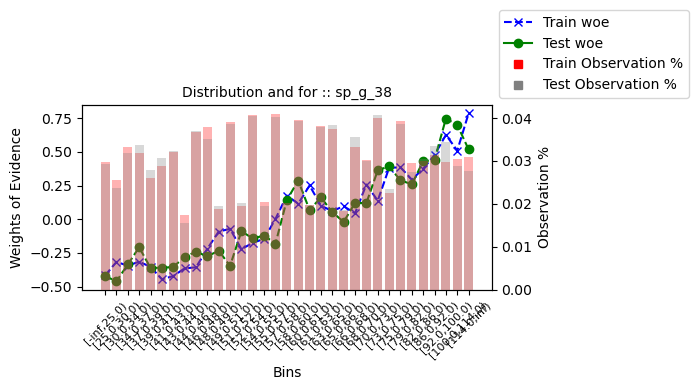

In [170]:
plot_woe(train_bins, test_bins, 'sp_g_38', metric='woe')

[INFO] creating woe binning ...
[INFO] creating woe binning ...


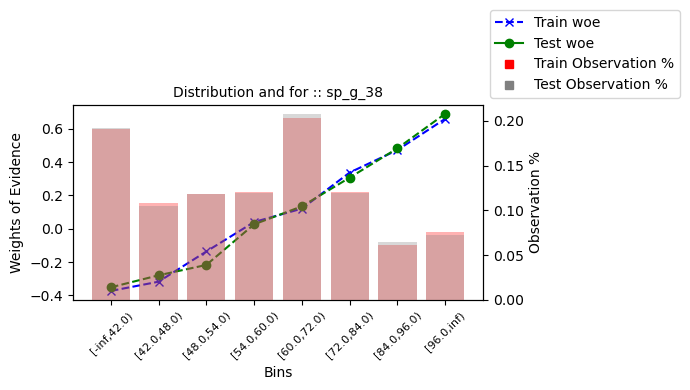

variable          bin  count  count_distr  good   bad   badprob       woe    bin_iv  total_iv breaks  is_special_values
0  sp_g_38  [-inf,42.0)   7669     0.191175  5285  2384  0.310862 -0.373140  0.029141  0.097872   42.0              False
1  sp_g_38  [42.0,48.0)   4353     0.108513  3051  1302  0.299104 -0.317665  0.011840  0.097872   48.0              False
2  sp_g_38  [48.0,54.0)   4746     0.118310  3500  1246  0.262537 -0.136408  0.002280  0.097872   54.0              False
3  sp_g_38  [54.0,60.0)   4857     0.121077  3741  1116  0.229771  0.040369  0.000195  0.097872   60.0              False
4  sp_g_38  [60.0,72.0)   8172     0.203714  6408  1764  0.215859  0.120730  0.002875  0.097872   72.0              False
5  sp_g_38  [72.0,84.0)   4844     0.120753  3965   879  0.181462  0.337243  0.012506  0.097872   84.0              False
6  sp_g_38  [84.0,96.0)   2453     0.061149  2055   398  0.162250  0.472346  0.011939  0.097872   96.0              False
7  sp_g_38   [96.0,inf)   3021     0.075308  2603   418  0.138365  0.659705  0.027098  0.097872    inf              False

In [171]:
# Define the features and target variable
features = ['sp_f3_34','sp_g_38']
target = 'gb_flag'
dt = train[features + [target]]
dt1 = test[features + [target]]

# original binning breaks list
breaks_list_new = {
      'sp_f3_34':[0.0,50,75,85,90.0,95.0,99.0,100,9999],
      'sp_g_38':[42,48,54,60,72,84,96]
      
    }

# Recalculate your bins and replot
train_bins_new = sc.woebin(dt, y=target, breaks_list=breaks_list_new)
test_bins_new = sc.woebin(dt1, y=target, breaks_list=breaks_list_new)

update_bins(train_bins_new)
update_bins(test_bins_new)

plot_woe(train_bins_new, test_bins_new, 'sp_g_38')
train_bins_new['sp_g_38']

In [172]:
# converting into woe transformed values
train_woe = sc.woebin_ply(dt, train_bins_new)
test_woe = sc.woebin_ply(dt1, test_bins_new)

y_train_woe = train_woe.loc[:,target]
X_train_woe = train_woe.loc[:,train_woe.columns != target]
y_test_woe = test_woe.loc[:,target]
X_test_woe = test_woe.loc[:,train_woe.columns != target]

# create logistic regression instance
# fit the model to the train data
# generate predicted values
from sklearn.linear_model import LogisticRegression
# lr = LogisticRegression(penalty='l1', C=0.9, solver='saga', n_jobs=-1)
lr = LogisticRegression()
lr.fit(X_train_woe, y_train_woe)

train_pred = lr.predict_proba(X_train_woe)[:,1]
test_pred = lr.predict_proba(X_test_woe)[:,1]

fpr_train, tpr_train, thresholds_train = roc_curve(y_train_woe, train_pred)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test_woe, test_pred)

auc_train = roc_auc_score(y_train_woe, train_pred)
auc_test = roc_auc_score(y_test_woe, test_pred)

gini_train = (2 * auc_train - 1)*100
gini_test = (2 * auc_test - 1)*100

print('---- Gini comparison ----')
print('Gini: %.2f' % gini_train)
print('Test Gini: %.2f' % gini_test)
print('Gini var: %.2f' % (100*abs(gini_train - gini_test) / gini_train))
print('---- End ----')

[INFO] converting into woe values ...
[INFO] converting into woe values ...
---- Gini comparison ----
Gini: 30.41
Test Gini: 30.08
Gini var: 1.08
---- End ----


In [173]:
pearson_corr = X_train_woe[:].corr(method='pearson')
spearman_corr = X_train_woe[:].corr(method='spearman')
condition_number = linalg.cond(X_train_woe.values)
eigenvalues, _ = linalg.eig(X_train_woe.corr())
kendall_corr = X_train_woe.corr(method='kendall')

# Add a constant term to the predictor variables
X_const = sm.add_constant(X_train_woe)
vif = pd.DataFrame()
vif["Variable"] = X_const.columns
vif["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

print('### Pearson\'s Correlation ###')
print(pearson_corr)
print('----------------------------------------')
print('----------------------------------------')
print('### Spearman\'s Correlation ###')
print(spearman_corr)
print('----------------------------------------')
print('----------------------------------------')
print('### Condition Number ###')
print(condition_number)
print('----------------------------------------')
print('----------------------------------------')
print('### Eigenvalues ###')
print(eigenvalues)
print('----------------------------------------')
print('----------------------------------------')
print('### Kendall\'s Tau ###')
print(kendall_corr)
print('----------------------------------------')
print('----------------------------------------')
print('### Variance Inflation Factor (VIF) ###')
print(vif)

### Pearson's Correlation ###
              sp_f3_34_woe  sp_g_38_woe
sp_f3_34_woe      1.000000     0.030074
sp_g_38_woe       0.030074     1.000000
----------------------------------------
----------------------------------------
### Spearman's Correlation ###
              sp_f3_34_woe  sp_g_38_woe
sp_f3_34_woe      1.000000     0.021741
sp_g_38_woe       0.021741     1.000000
----------------------------------------
----------------------------------------
### Condition Number ###
1.4657660949427025
----------------------------------------
----------------------------------------
### Eigenvalues ###
[1.03007351 0.96992649]
----------------------------------------
----------------------------------------
### Kendall's Tau ###
              sp_f3_34_woe  sp_g_38_woe
sp_f3_34_woe      1.000000     0.016455
sp_g_38_woe       0.016455     1.000000
----------------------------------------
----------------------------------------
### Variance Inflation Factor (VIF) ###
       Variable    

In [174]:
# run a different model type to get nicer outputs - results are the same
logit_model = sm.Logit(y_train_woe, sm.add_constant(X_train_woe))
sm_result = logit_model.fit()

# Get the p-values for each predictor variable
sm_result.summary2()

Optimization terminated successfully.
         Current function value: 0.520972
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.049     
Dependent Variable: gb_flag          AIC:              41803.5865
Date:               2023-08-15 14:23 BIC:              41829.3851
No. Observations:   40115            Log-Likelihood:   -20899.   
Df Model:           2                LL-Null:          -21967.   
Df Residuals:       40112            LLR p-value:      0.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
const            -1.1696   0.0122 -95.9589 0.0000 -1.1935 -1.1457
sp_f3_34_woe     -0.9999   0.0272 -36.7036 0.0000 -1.0533 -0.9465
sp_g_38_woe      -1.0002   0.0395 -25.3145 0.0000 -1.0777 -0.9228
=================================================================

"""

In [175]:
result_miv = calculate_miv_exp_woe()

print('The variable with highest MIV is:',next(iter(result_miv)),'// with MIV of:', result_miv[next(iter(result_miv))])
print()
print("\n".join(f"{key}: {value}" for key, value in list(result_miv.items())[:30]))

The variable with highest MIV is: Score2_woe // with MIV of: {'TotIV': 0.2302487562897894, 'TotMIV': 0.11890327731494588}

Score2_woe: {'TotIV': 0.2302487562897894, 'TotMIV': 0.11890327731494588}
e5_s_05_2_all_woe: {'TotIV': 0.2302487562897894, 'TotMIV': 0.11890327731494588}
nd_sp_ciisp_woe: {'TotIV': 0.23653465060353318, 'TotMIV': 0.10892396799844586}
Score1_woe: {'TotIV': 0.19673882244020777, 'TotMIV': 0.10624439534822692}
e5_s_05_1_all_woe: {'TotIV': 0.19673882244020777, 'TotMIV': 0.10624439534822692}
e1_b_07sp_woe: {'TotIV': 0.09986819290918, 'TotMIV': 0.07371394927305766}
e1_b_08sp_woe: {'TotIV': 0.09269175390693002, 'TotMIV': 0.06920642724692347}
sp_a_08_woe: {'TotIV': 0.09280683275397118, 'TotMIV': 0.06850694291542259}
e4_q_17sp_woe: {'TotIV': 0.0785544043899635, 'TotMIV': 0.05794364452385155}
nd_hac_02sp_woe: {'TotIV': 0.08070906465774771, 'TotMIV': 0.05734544212557766}
e1_b_12sp_woe: {'TotIV': 0.07840772294786998, 'TotMIV': 0.05666061311827021}
nd_hac_04sp_woe: {'TotIV': 0.080

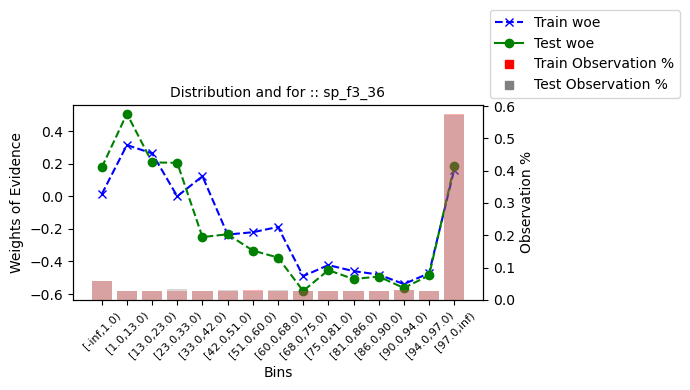

variable          bin  count  count_distr   good   bad   badprob       woe        bin_iv  total_iv breaks  is_special_values
0   sp_f3_36   [-inf,1.0)   2399     0.059803   1836   563  0.234681  0.012832  9.813777e-06  0.066955    1.0              False
1   sp_f3_36   [1.0,13.0)   1131     0.028194    922   209  0.184792  0.314978  2.563619e-03  0.066955   13.0              False
2   sp_f3_36  [13.0,23.0)   1054     0.026274    851   203  0.192600  0.263973  1.702759e-03  0.066955   23.0              False
3   sp_f3_36  [23.0,33.0)   1148     0.028618    876   272  0.236934  0.000331  3.134760e-09  0.066955   33.0              False
4   sp_f3_36  [33.0,42.0)   1105     0.027546    867   238  0.215385  0.123535  4.066463e-04  0.066955   42.0              False
5   sp_f3_36  [42.0,51.0)   1149     0.028643    825   324  0.281984 -0.234593  1.671808e-03  0.066955   51.0              False
6   sp_f3_36  [51.0,60.0)   1211     0.030188    873   338  0.279108 -0.220343  1.549189e-03  0.066955   60.0              False
7   sp_f3_36  [60.0,68.0)   1137     0.028344    827   310  0.272647 -0.188001  1.050636e-03  0.066955   68.0              False
8   sp_f3_36  [68.0,75.0)   1079     0.026898    716   363  0.336423 -0.489956  7.246354e-03  0.066955   75.0              False
9   sp_f3_36  [75.0,81.0)   1098     0.027371    745   353  0.321494 -0.422317  5.401641e-03  0.066955   81.0              False
10  sp_f3_36  [81.0,86.0)   1153     0.028742    773   380  0.329575 -0.459125  6.756355e-03  0.066955   86.0              False
11  sp_f3_36  [86.0,90.0)   1074     0.026773    715   359  0.334264 -0.480273  6.916767e-03  0.066955   90.0              False
12  sp_f3_36  [90.0,94.0)   1235     0.030786    806   429  0.347368 -0.538606  1.012131e-02  0.066955   94.0              False
13  sp_f3_36  [94.0,97.0)   1068     0.026623    713   355  0.332397 -0.471869  6.628040e-03  0.066955   97.0              False
14  sp_f3_36   [97.0,inf)  23074     0.575196  18263  4811  0.208503  0.164739  1.492963e-02  0.066955    inf              False

In [176]:
plot_woe(train_bins, test_bins, 'sp_f3_36', metric='woe')
train_bins['sp_f3_36']

[INFO] creating woe binning ...
[INFO] creating woe binning ...


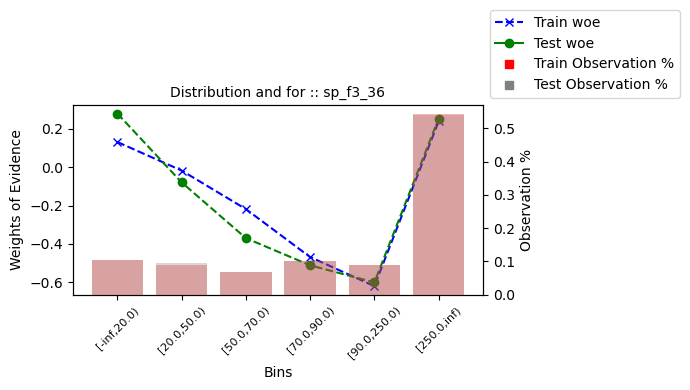

variable           bin  count  count_distr   good   bad   badprob       woe    bin_iv  total_iv breaks  is_special_values
0  sp_f3_36   [-inf,20.0)   4248     0.105896   3339   909  0.213983  0.131849  0.001777  0.099222   20.0              False
1  sp_f3_36   [20.0,50.0)   3590     0.089493   2728   862  0.240111 -0.017164  0.000026  0.099222   50.0              False
2  sp_f3_36   [50.0,70.0)   2791     0.069575   2013   778  0.278753 -0.218578  0.003512  0.099222   70.0              False
3  sp_f3_36   [70.0,90.0)   4109     0.102431   2746  1363  0.331711 -0.468776  0.025151  0.099222   90.0              False
4  sp_f3_36  [90.0,250.0)   3585     0.089368   2272  1313  0.366248 -0.620887  0.039662  0.099222  250.0              False
5  sp_f3_36   [250.0,inf)  21792     0.543238  17510  4282  0.196494  0.239119  0.029093  0.099222    inf              False

In [177]:
# Define the features and target variable
features = ['sp_f3_34','sp_g_38','sp_f3_36']
target = 'gb_flag'
dt = train[features + [target]]
dt1 = test[features + [target]]

# original binning breaks list
breaks_list_new = {
      'sp_f3_34':[0.0,50,75,85,90.0,95.0,97.0,100,9999],
      'sp_g_38':[42,48,54,60,72,84,96],
      'sp_f3_36':[-1,20,50,70,90,250,9999]
    }

# Recalculate your bins and replot
train_bins_new = sc.woebin(dt, y=target, breaks_list=breaks_list_new)
test_bins_new = sc.woebin(dt1, y=target, breaks_list=breaks_list_new)

update_bins(train_bins_new)
update_bins(test_bins_new)

plot_woe(train_bins_new, test_bins_new, 'sp_f3_36')
train_bins_new['sp_f3_36']

In [179]:
# converting into woe transformed values
train_woe = sc.woebin_ply(dt, train_bins_new)
test_woe = sc.woebin_ply(dt1, test_bins_new)

y_train_woe = train_woe.loc[:,target]
X_train_woe = train_woe.loc[:,train_woe.columns != target]
y_test_woe = test_woe.loc[:,target]
X_test_woe = test_woe.loc[:,train_woe.columns != target]

# create logistic regression instance
# fit the model to the train data
# generate predicted values
from sklearn.linear_model import LogisticRegression
# lr = LogisticRegression(penalty='l1', C=0.9, solver='saga', n_jobs=-1)
lr = LogisticRegression()
lr.fit(X_train_woe, y_train_woe)

train_pred = lr.predict_proba(X_train_woe)[:,1]
test_pred = lr.predict_proba(X_test_woe)[:,1]

fpr_train, tpr_train, thresholds_train = roc_curve(y_train_woe, train_pred)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test_woe, test_pred)

auc_train = roc_auc_score(y_train_woe, train_pred)
auc_test = roc_auc_score(y_test_woe, test_pred)

gini_train = (2 * auc_train - 1)*100
gini_test = (2 * auc_test - 1)*100

print('---- Gini comparison ----')
print('Gini: %.2f' % gini_train)
print('Test Gini: %.2f' % gini_test)
print('Gini var: %.2f' % (100*abs(gini_train - gini_test) / gini_train))
print('---- End ----')

[INFO] converting into woe values ...
[INFO] converting into woe values ...
---- Gini comparison ----
Gini: 31.44
Test Gini: 31.72
Gini var: 0.90
---- End ----


In [180]:
X_train_woe[:].corr()

sp_f3_36_woe  sp_f3_34_woe  sp_g_38_woe
sp_f3_36_woe      1.000000      0.316638     0.168793
sp_f3_34_woe      0.316638      1.000000     0.030973
sp_g_38_woe       0.168793      0.030973     1.000000

In [181]:
# run a different model type to get nicer outputs - results are the same
logit_model = sm.Logit(y_train_woe, sm.add_constant(X_train_woe))
sm_result = logit_model.fit()

# Get the p-values for each predictor variable
sm_result.summary2()

Optimization terminated successfully.
         Current function value: 0.519227
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.052     
Dependent Variable: gb_flag          AIC:              41665.6042
Date:               2023-08-15 14:24 BIC:              41700.0022
No. Observations:   40115            Log-Likelihood:   -20829.   
Df Model:           3                LL-Null:          -21967.   
Df Residuals:       40111            LLR p-value:      0.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
const            -1.1696   0.0122 -95.7499 0.0000 -1.1935 -1.1456
sp_f3_36_woe     -0.4632   0.0390 -11.8747 0.0000 -0.5397 -0.3868
sp_f3_34_woe     -0.9020   0.0285 -31.6247 0.0000 -0.9579 -0.8461
sp_g_38_woe      -0.9245   0.0400 -23.0992 0.0000 -1.0030 -0.8461
=================================================================

"""

In [182]:
result_miv = calculate_miv_exp_woe()

print('The variable with highest MIV is:',next(iter(result_miv)),'// with MIV of:', result_miv[next(iter(result_miv))])
print()
print("\n".join(f"{key}: {value}" for key, value in list(result_miv.items())[:30]))

The variable with highest MIV is: Score2_woe // with MIV of: {'TotIV': 0.2302487562897894, 'TotMIV': 0.11890327731494588}

Score2_woe: {'TotIV': 0.2302487562897894, 'TotMIV': 0.11890327731494588}
e5_s_05_2_all_woe: {'TotIV': 0.2302487562897894, 'TotMIV': 0.11890327731494588}
nd_sp_ciisp_woe: {'TotIV': 0.23653465060353318, 'TotMIV': 0.10892396799844586}
Score1_woe: {'TotIV': 0.19673882244020777, 'TotMIV': 0.10624439534822692}
e5_s_05_1_all_woe: {'TotIV': 0.19673882244020777, 'TotMIV': 0.10624439534822692}
e1_b_07sp_woe: {'TotIV': 0.09986819290918, 'TotMIV': 0.07371394927305766}
e1_b_08sp_woe: {'TotIV': 0.09269175390693002, 'TotMIV': 0.06920642724692347}
sp_a_08_woe: {'TotIV': 0.09280683275397118, 'TotMIV': 0.06850694291542259}
e4_q_17sp_woe: {'TotIV': 0.0785544043899635, 'TotMIV': 0.05794364452385155}
nd_hac_02sp_woe: {'TotIV': 0.08070906465774771, 'TotMIV': 0.05734544212557766}
e1_b_12sp_woe: {'TotIV': 0.07840772294786998, 'TotMIV': 0.05666061311827021}
nd_hac_04sp_woe: {'TotIV': 0.080

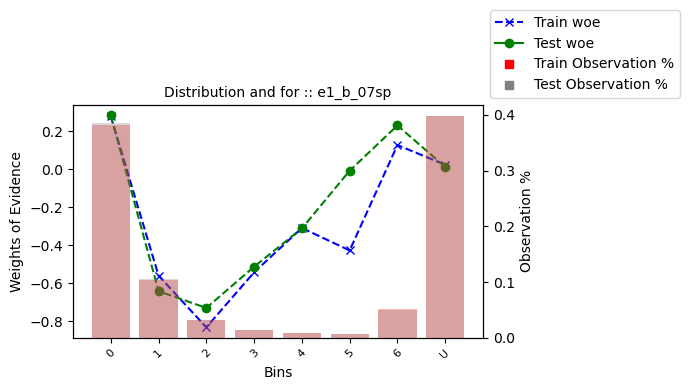

variable bin  count  count_distr   good   bad   badprob       woe    bin_iv  total_iv breaks  is_special_values
0  e1_b_07sp   0  15343     0.382475  12423  2920  0.190315  0.278733  0.027520  0.099841      0              False
1  e1_b_07sp   1   4139     0.103178   2681  1458  0.352259 -0.560109  0.036838  0.099841      1              False
2  e1_b_07sp   2   1306     0.032556    762   544  0.416539 -0.832236  0.026902  0.099841      2              False
3  e1_b_07sp   3    600     0.014957    391   209  0.348333 -0.542860  0.004999  0.099841      3              False
4  e1_b_07sp   4    380     0.009473    267   113  0.297368 -0.309372  0.000978  0.099841      4              False
5  e1_b_07sp   5    313     0.007803    212   101  0.322684 -0.427767  0.001582  0.099841      5              False
6  e1_b_07sp   6   2104     0.052449   1652   452  0.214829  0.126827  0.000815  0.099841      6              False
7  e1_b_07sp   U  15930     0.397108  12220  3710  0.232894  0.022809  0.000205  0.099841      U              False

In [183]:
plot_woe(train_bins, test_bins, 'e1_b_07sp', metric='woe')
train_bins['e1_b_07sp']

[INFO] creating woe binning ...
[INFO] creating woe binning ...


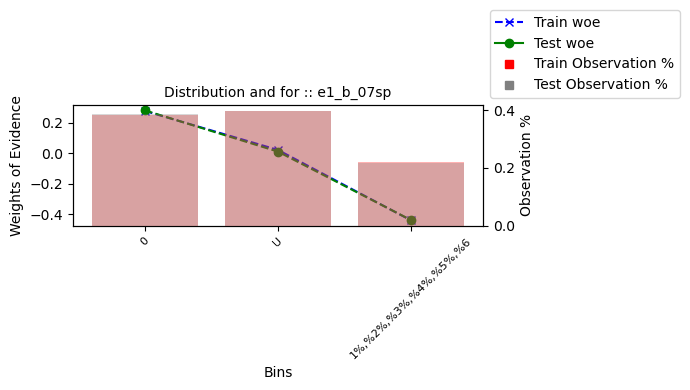

variable                    bin  count  count_distr   good   bad   badprob       woe    bin_iv  total_iv                 breaks  is_special_values
0  e1_b_07sp                      0  15343     0.382475  12423  2920  0.190315  0.278733  0.027520  0.075137                      0              False
1  e1_b_07sp                      U  15930     0.397108  12220  3710  0.232894  0.022809  0.000205  0.075137                      U              False
2  e1_b_07sp  1%,%2%,%3%,%4%,%5%,%6   8842     0.220416   5965  2877  0.325379 -0.440072  0.047411  0.075137  1%,%2%,%3%,%4%,%5%,%6              False

In [184]:
# Define the features and target variable
features = ['sp_f3_34','sp_g_38','sp_f3_36','e1_b_07sp']
target = 'gb_flag'
dt = train[features + [target]]
dt1 = test[features + [target]]

# original binning breaks list
breaks_list_new = {
      'sp_f3_34':[0.0,50,75,85,90.0,95.0,97.0,100,9999],
      'sp_g_38':[42,48,54,60,72,84,96],
      'sp_f3_36':[-1,20,50,70,90,250,9999],
      'e1_b_07sp':['0','U','1%,%2%,%3%,%4%,%5%,%6']
    }

# Recalculate your bins and replot
train_bins_new = sc.woebin(dt, y=target, breaks_list=breaks_list_new)
test_bins_new = sc.woebin(dt1, y=target, breaks_list=breaks_list_new)

update_bins(train_bins_new)
update_bins(test_bins_new)

plot_woe(train_bins_new, test_bins_new, 'e1_b_07sp')
train_bins_new['e1_b_07sp']

In [185]:
# converting into woe transformed values
train_woe = sc.woebin_ply(dt, train_bins_new)
test_woe = sc.woebin_ply(dt1, test_bins_new)

y_train_woe = train_woe.loc[:,target]
X_train_woe = train_woe.loc[:,train_woe.columns != target]
y_test_woe = test_woe.loc[:,target]
X_test_woe = test_woe.loc[:,train_woe.columns != target]

# create logistic regression instance
# fit the model to the train data
# generate predicted values
from sklearn.linear_model import LogisticRegression
# lr = LogisticRegression(penalty='l1', C=0.9, solver='saga', n_jobs=-1)
lr = LogisticRegression()
lr.fit(X_train_woe, y_train_woe)

train_pred = lr.predict_proba(X_train_woe)[:,1]
test_pred = lr.predict_proba(X_test_woe)[:,1]

fpr_train, tpr_train, thresholds_train = roc_curve(y_train_woe, train_pred)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test_woe, test_pred)

auc_train = roc_auc_score(y_train_woe, train_pred)
auc_test = roc_auc_score(y_test_woe, test_pred)

gini_train = (2 * auc_train - 1)*100
gini_test = (2 * auc_test - 1)*100

print('---- Gini comparison ----')
print('Gini: %.2f' % gini_train)
print('Test Gini: %.2f' % gini_test)
print('Gini var: %.2f' % (100*abs(gini_train - gini_test) / gini_train))
print('---- End ----')

[INFO] converting into woe values ...
[INFO] converting into woe values ...
---- Gini comparison ----
Gini: 32.93
Test Gini: 33.00
Gini var: 0.21
---- End ----


In [186]:
X_train_woe[:].corr()

sp_f3_36_woe  sp_f3_34_woe  sp_g_38_woe  e1_b_07sp_woe
sp_f3_36_woe       1.000000      0.316638     0.168793       0.118003
sp_f3_34_woe       0.316638      1.000000     0.030973       0.162606
sp_g_38_woe        0.168793      0.030973     1.000000       0.005578
e1_b_07sp_woe      0.118003      0.162606     0.005578       1.000000

In [187]:
# run a different model type to get nicer outputs - results are the same
logit_model = sm.Logit(y_train_woe, sm.add_constant(X_train_woe))
sm_result = logit_model.fit()

# Get the p-values for each predictor variable
sm_result.summary2()

Optimization terminated successfully.
         Current function value: 0.515537
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.059     
Dependent Variable: gb_flag          AIC:              41371.5448
Date:               2023-08-15 14:24 BIC:              41414.5423
No. Observations:   40115            Log-Likelihood:   -20681.   
Df Model:           4                LL-Null:          -21967.   
Df Residuals:       40110            LLR p-value:      0.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
const            -1.1696   0.0123 -95.2888 0.0000 -1.1937 -1.1455
sp_f3_36_woe     -0.4208   0.0393 -10.7059 0.0000 -0.4978 -0.3438
sp_f3_34_woe     -0.8374   0.0288 -29.1217 0.0000 -0.8938 -0.7810
sp_g_38_woe      -0.9481   0.0403 -23.5366 0.0000 -1.0270 -0.8691
e1_b_07sp_woe    -0.7729   0.0446 -17.3132 0.0000 -0.8604 -0.6854
=================================================================

"""

In [188]:
result_miv = calculate_miv_exp_woe()

print('The variable with highest MIV is:',next(iter(result_miv)),'// with MIV of:', result_miv[next(iter(result_miv))])
print()
print("\n".join(f"{key}: {value}" for key, value in list(result_miv.items())[:30]))

The variable with highest MIV is: Score2_woe // with MIV of: {'TotIV': 0.2302487562897894, 'TotMIV': 0.11890327731494588}

Score2_woe: {'TotIV': 0.2302487562897894, 'TotMIV': 0.11890327731494588}
e5_s_05_2_all_woe: {'TotIV': 0.2302487562897894, 'TotMIV': 0.11890327731494588}
nd_sp_ciisp_woe: {'TotIV': 0.23653465060353318, 'TotMIV': 0.10892396799844586}
Score1_woe: {'TotIV': 0.19673882244020777, 'TotMIV': 0.10624439534822692}
e5_s_05_1_all_woe: {'TotIV': 0.19673882244020777, 'TotMIV': 0.10624439534822692}
e1_b_08sp_woe: {'TotIV': 0.09269175390693002, 'TotMIV': 0.06920642724692347}
sp_a_08_woe: {'TotIV': 0.09280683275397118, 'TotMIV': 0.06850694291542259}
e4_q_17sp_woe: {'TotIV': 0.0785544043899635, 'TotMIV': 0.05794364452385155}
nd_hac_02sp_woe: {'TotIV': 0.08070906465774771, 'TotMIV': 0.05734544212557766}
e1_b_12sp_woe: {'TotIV': 0.07840772294786998, 'TotMIV': 0.05666061311827021}
nd_hac_04sp_woe: {'TotIV': 0.08050605308874703, 'TotMIV': 0.0564935765362744}
e1_c_01sp_woe: {'TotIV': 0.0

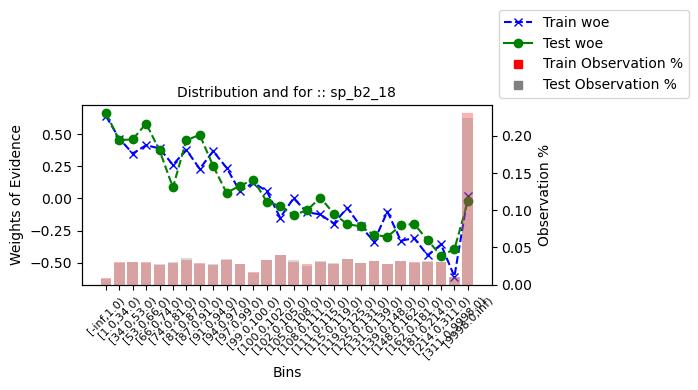

variable             bin  count  count_distr  good   bad   badprob       woe        bin_iv  total_iv  breaks  is_special_values
0   sp_b2_18      [-inf,1.0)    356     0.008874   306    50  0.140449  0.642329  3.043422e-03  0.064178     1.0              False
1   sp_b2_18      [1.0,34.0)   1196     0.029814  1001   195  0.163043  0.466522  5.688149e-03  0.064178    34.0              False
2   sp_b2_18     [34.0,53.0)   1203     0.029989   987   216  0.179551  0.350159  3.335740e-03  0.064178    53.0              False
3   sp_b2_18     [53.0,66.0)   1216     0.030313  1009   207  0.170230  0.414763  4.641950e-03  0.064178    66.0              False
4   sp_b2_18     [66.0,74.0)   1082     0.026972   894   188  0.173752  0.390031  3.679218e-03  0.064178    74.0              False
5   sp_b2_18     [74.0,81.0)   1156     0.028817   933   223  0.192907  0.262000  1.840769e-03  0.064178    81.0              False
6   sp_b2_18     [81.0,87.0)   1340     0.033404  1105   235  0.175373  0.378782  4.311693e-03  0.064178    87.0              False
7   sp_b2_18     [87.0,91.0)   1188     0.029615   953   235  0.197811  0.230796  1.481025e-03  0.064178    91.0              False
8   sp_b2_18     [91.0,94.0)   1080     0.026923   889   191  0.176852  0.368591  3.300448e-03  0.064178    94.0              False
9   sp_b2_18     [94.0,97.0)   1324     0.033005  1064   260  0.196375  0.239876  1.778413e-03  0.064178    97.0              False
10  sp_b2_18     [97.0,99.0)   1131     0.028194   874   257  0.227233  0.054771  8.335710e-05  0.064178    99.0              False
11  sp_b2_18    [99.0,100.0)    673     0.016777   528   145  0.215453  0.123129  2.460709e-04  0.064178   100.0              False
12  sp_b2_18   [100.0,102.0)   1345     0.033529  1040   305  0.226766  0.057431  1.089137e-04  0.064178   102.0              False
13  sp_b2_18   [102.0,105.0)   1585     0.039511  1165   420  0.264984 -0.149011  9.113581e-04  0.064178   105.0              False
14  sp_b2_18   [105.0,108.0)   1238     0.030861   945   293  0.236672  0.001779  9.765552e-08  0.064178   108.0              False
15  sp_b2_18   [108.0,111.0)   1125     0.028044   836   289  0.256889 -0.107031  3.302480e-04  0.064178   111.0              False
16  sp_b2_18   [111.0,115.0)   1226     0.030562   907   319  0.260196 -0.124282  4.873641e-04  0.064178   115.0              False
17  sp_b2_18   [115.0,119.0)   1127     0.028094   818   309  0.274179 -0.195712  1.130692e-03  0.064178   119.0              False
18  sp_b2_18   [119.0,125.0)   1405     0.035024  1053   352  0.250534 -0.073466  1.926696e-04  0.064178   125.0              False
19  sp_b2_18   [125.0,131.0)   1187     0.029590   857   330  0.278012 -0.214888  1.442337e-03  0.064178   131.0              False
20  sp_b2_18   [131.0,139.0)   1258     0.031360   877   381  0.302862 -0.335525  3.832738e-03  0.064178   139.0              False
21  sp_b2_18   [139.0,148.0)   1141     0.028443   849   292  0.255916 -0.101928  3.033738e-04  0.064178   148.0              False
22  sp_b2_18   [148.0,162.0)   1271     0.031684   888   383  0.301338 -0.328296  3.701239e-03  0.064178   162.0              False
23  sp_b2_18   [162.0,181.0)   1207     0.030088   848   359  0.297432 -0.309675  3.114237e-03  0.064178   181.0              False
24  sp_b2_18   [181.0,214.0)   1206     0.030064   813   393  0.325871 -0.442312  6.535718e-03  0.064178   214.0              False
25  sp_b2_18   [214.0,311.0)   1209     0.030138   837   372  0.307692 -0.358303  4.221979e-03  0.064178   311.0              False
26  sp_b2_18  [311.0,9998.0)    413     0.010295   263   150  0.363196 -0.607714  4.366624e-03  0.064178  9998.0              False
27  sp_b2_18    [9998.0,inf)   9227     0.230014  7069  2158  0.233879  0.017304  6.855984e-05  0.064178     inf              False

In [189]:
plot_woe(train_bins, test_bins, 'sp_b2_18', metric='woe')
train_bins['sp_b2_18']

[INFO] creating woe binning ...
[INFO] creating woe binning ...


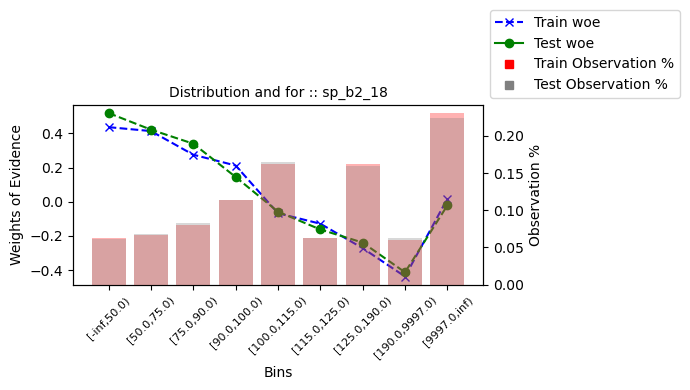

variable             bin  count  count_distr  good   bad   badprob       woe    bin_iv  total_iv  breaks  is_special_values
0  sp_b2_18     [-inf,50.0)   2530     0.063069  2107   423  0.167194  0.436415  0.010624  0.058573    50.0              False
1  sp_b2_18     [50.0,75.0)   2658     0.066260  2205   453  0.170429  0.413358  0.010082  0.058573    75.0              False
2  sp_b2_18     [75.0,90.0)   3206     0.079920  2594   612  0.190892  0.274991  0.005603  0.058573    90.0              False
3  sp_b2_18    [90.0,100.0)   4551     0.113449  3637   914  0.200835  0.211851  0.004806  0.058573   100.0              False
4  sp_b2_18   [100.0,115.0)   6519     0.162508  4893  1626  0.249425 -0.067550  0.000755  0.058573   115.0              False
5  sp_b2_18   [115.0,125.0)   2532     0.063119  1871   661  0.261058 -0.128759  0.001082  0.058573   125.0              False
6  sp_b2_18   [125.0,190.0)   6485     0.161660  4607  1878  0.289591 -0.271864  0.012784  0.058573   190.0              False
7  sp_b2_18  [190.0,9997.0)   2407     0.060002  1625   782  0.324886 -0.437825  0.012769  0.058573  9997.0              False
8  sp_b2_18    [9997.0,inf)   9227     0.230014  7069  2158  0.233879  0.017304  0.000069  0.058573     inf              False

In [190]:
# Define the features and target variable
features = ['sp_f3_34','sp_g_38','sp_f3_36','e1_b_07sp','sp_b2_18']
target = 'gb_flag'
dt = train[features + [target]]
dt1 = test[features + [target]]

# original binning breaks list
breaks_list_new = {
      'sp_f3_34':[0.0,50,75,85,90.0,95.0,97.0,100,9999],
      'sp_g_38':[42,48,54,60,72,84,96],
      'sp_f3_36':[-1,20,50,70,90,250,9999],
      'e1_b_07sp':['0','U','1%,%2%,%3%,%4%,%5%,%6'],
      'sp_b2_18':[50,75,90,100,115,125,190,9997]
    }

# Recalculate your bins and replot
train_bins_new = sc.woebin(dt, y=target, breaks_list=breaks_list_new)
test_bins_new = sc.woebin(dt1, y=target, breaks_list=breaks_list_new)

update_bins(train_bins_new)
update_bins(test_bins_new)

plot_woe(train_bins_new, test_bins_new, 'sp_b2_18')
train_bins_new['sp_b2_18']

In [191]:
# converting into woe transformed values
train_woe = sc.woebin_ply(dt, train_bins_new)
test_woe = sc.woebin_ply(dt1, test_bins_new)

y_train_woe = train_woe.loc[:,target]
X_train_woe = train_woe.loc[:,train_woe.columns != target]
y_test_woe = test_woe.loc[:,target]
X_test_woe = test_woe.loc[:,train_woe.columns != target]

# create logistic regression instance
# fit the model to the train data
# generate predicted values
from sklearn.linear_model import LogisticRegression
# lr = LogisticRegression(penalty='l1', C=0.9, solver='saga', n_jobs=-1)
lr = LogisticRegression()
lr.fit(X_train_woe, y_train_woe)

train_pred = lr.predict_proba(X_train_woe)[:,1]
test_pred = lr.predict_proba(X_test_woe)[:,1]

fpr_train, tpr_train, thresholds_train = roc_curve(y_train_woe, train_pred)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test_woe, test_pred)

auc_train = roc_auc_score(y_train_woe, train_pred)
auc_test = roc_auc_score(y_test_woe, test_pred)

gini_train = (2 * auc_train - 1)*100
gini_test = (2 * auc_test - 1)*100

print('---- Gini comparison ----')
print('Gini: %.2f' % gini_train)
print('Test Gini: %.2f' % gini_test)
print('Gini var: %.2f' % (100*abs(gini_train - gini_test) / gini_train))
print('---- End ----')

[INFO] converting into woe values ...
[INFO] converting into woe values ...
---- Gini comparison ----
Gini: 33.61
Test Gini: 33.94
Gini var: 0.97
---- End ----


In [192]:
X_train_woe[:].corr()

sp_g_38_woe  sp_f3_36_woe  e1_b_07sp_woe  sp_f3_34_woe  sp_b2_18_woe
sp_g_38_woe       1.000000      0.168793       0.005578      0.030973      0.058330
sp_f3_36_woe      0.168793      1.000000       0.118003      0.316638      0.094947
e1_b_07sp_woe     0.005578      0.118003       1.000000      0.162606     -0.023075
sp_f3_34_woe      0.030973      0.316638       0.162606      1.000000      0.248744
sp_b2_18_woe      0.058330      0.094947      -0.023075      0.248744      1.000000

In [193]:
# run a different model type to get nicer outputs - results are the same
logit_model = sm.Logit(y_train_woe, sm.add_constant(X_train_woe))
sm_result = logit_model.fit()

# Get the p-values for each predictor variable
sm_result.summary2()

Optimization terminated successfully.
         Current function value: 0.513752
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.062     
Dependent Variable: gb_flag          AIC:              41230.3067
Date:               2023-08-15 14:25 BIC:              41281.9037
No. Observations:   40115            Log-Likelihood:   -20609.   
Df Model:           5                LL-Null:          -21967.   
Df Residuals:       40109            LLR p-value:      0.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
const            -1.1703   0.0123 -95.0821 0.0000 -1.1945 -1.1462
sp_g_38_woe      -0.9272   0.0404 -22.9702 0.0000 -1.0063 -0.8481
sp_f3_36_woe     -0.4127   0.0394 -10.4797 0.0000 -0.4899 -0.3355
e1_b_07sp_woe    -0.8106   0.0448 -18.0839 0.0000 -0.8985 -0.7228
sp_f3_34_woe     -0.7671   0.0294 -26.0500 0.0000 -0.8248 -0.7094
sp_b2_18_woe     -0.6226   0.0522 -11.9288 0.0000 -0.7249 -0.5203
=================================================================

"""

In [195]:
result_miv = calculate_miv_exp_woe()

print('The variable with highest MIV is:',next(iter(result_miv)),'// with MIV of:', result_miv[next(iter(result_miv))])
print()
print("\n".join(f"{key}: {value}" for key, value in list(result_miv.items())[30:60]))

The variable with highest MIV is: Score2_woe // with MIV of: {'TotIV': 0.2302487562897894, 'TotMIV': 0.11890327731494588}

e1_e_02sp_woe: {'TotIV': 0.037059203693473056, 'TotMIV': 0.03052806011360132}
sp_a_06_woe: {'TotIV': 0.031544573946244645, 'TotMIV': 0.03025456971625949}
clu_cli_l6m_woe: {'TotIV': 0.07891231762430609, 'TotMIV': 0.030085022555736647}
sp_h_41_woe: {'TotIV': 0.025074556329501053, 'TotMIV': 0.028918493903471672}
sp_f1_30_woe: {'TotIV': 0.18244033301399304, 'TotMIV': 0.02870012342116974}
sp_h_40_woe: {'TotIV': 0.03125164713203813, 'TotMIV': 0.027865086672290925}
sp_g_37_woe: {'TotIV': 0.024220620538505898, 'TotMIV': 0.02748766178710383}
sp_b1_11_woe: {'TotIV': 0.06306685544719273, 'TotMIV': 0.027400024117202305}
nd_ecc_03sp_woe: {'TotIV': 0.03361313575348219, 'TotMIV': 0.027177280926239233}
ea1_e_02sp_woe: {'TotIV': 0.03180907292006574, 'TotMIV': 0.02635486056373375}
sp_f3_35_woe: {'TotIV': 0.15461063689570745, 'TotMIV': 0.026165665596732078}
nd_hac_01sp_woe: {'TotIV':

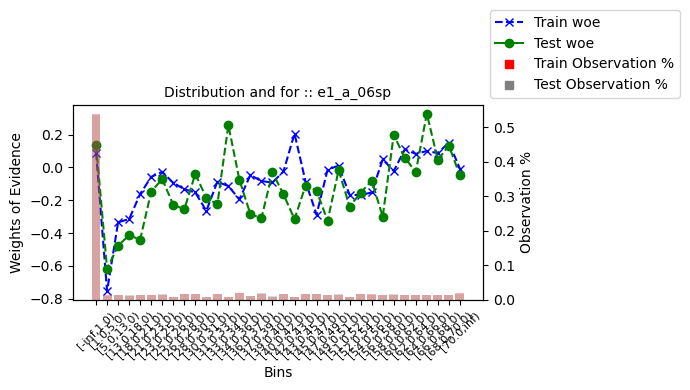

variable          bin  count  count_distr   good   bad   badprob       woe    bin_iv  total_iv breaks  is_special_values
0   e1_a_06sp   [-inf,1.0)  21593     0.538277  16818  4775  0.221136  0.089823  0.004240  0.023366    1.0              False
1   e1_a_06sp    [1.0,5.0)    556     0.013860    335   221  0.397482 -0.753265  0.009266  0.023366    5.0              False
2   e1_a_06sp   [5.0,13.0)    555     0.013835    387   168  0.302703 -0.334772  0.001683  0.023366   13.0              False
3   e1_a_06sp  [13.0,18.0)    459     0.011442    322   137  0.298475 -0.314662  0.001224  0.023366   18.0              False
4   e1_a_06sp  [18.0,21.0)    598     0.014907    438   160  0.267559 -0.162188  0.000409  0.023366   21.0              False
5   e1_a_06sp  [21.0,23.0)    517     0.012888    389   128  0.247582 -0.057684  0.000044  0.023366   23.0              False
6   e1_a_06sp  [23.0,25.0)    587     0.014633    445   142  0.241908 -0.026986  0.000011  0.023366   25.0              False
7   e1_a_06sp  [25.0,26.0)    342     0.008525    255    87  0.254386 -0.093878  0.000077  0.023366   26.0              False
8   e1_a_06sp  [26.0,28.0)    699     0.017425    516   183  0.261803 -0.132612  0.000317  0.023366   28.0              False
9   e1_a_06sp  [28.0,30.0)    700     0.017450    514   186  0.265714 -0.152756  0.000423  0.023366   30.0              False
10  e1_a_06sp  [30.0,31.0)    354     0.008825    252   102  0.288136 -0.264777  0.000661  0.023366   31.0              False
11  e1_a_06sp  [31.0,33.0)    703     0.017525    525   178  0.253201 -0.087618  0.000138  0.023366   33.0              False
12  e1_a_06sp  [33.0,34.0)    368     0.009174    273    95  0.258152 -0.113638  0.000122  0.023366   34.0              False
13  e1_a_06sp  [34.0,36.0)    770     0.019195    559   211  0.274026 -0.194942  0.000766  0.023366   36.0              False
14  e1_a_06sp  [36.0,37.0)    391     0.009747    295    96  0.245524 -0.046606  0.000021  0.023366   37.0              False
15  e1_a_06sp  [37.0,39.0)    729     0.018173    545   184  0.252401 -0.083383  0.000129  0.023366   39.0              False
16  e1_a_06sp  [39.0,40.0)    374     0.009323    279    95  0.254011 -0.091898  0.000081  0.023366   40.0              False
17  e1_a_06sp  [40.0,42.0)    733     0.018272    556   177  0.241473 -0.024614  0.000011  0.023366   42.0              False
18  e1_a_06sp  [42.0,43.0)    352     0.008775    281    71  0.201705  0.206442  0.000354  0.023366   43.0              False
19  e1_a_06sp  [43.0,45.0)    664     0.016552    496   168  0.253012 -0.086621  0.000127  0.023366   45.0              False
20  e1_a_06sp  [45.0,47.0)    625     0.015580    442   183  0.292800 -0.287409  0.001382  0.023366   47.0              False
21  e1_a_06sp  [47.0,49.0)    614     0.015306    467   147  0.239414 -0.013336  0.000003  0.023366   49.0              False
22  e1_a_06sp  [49.0,51.0)    604     0.015057    462   142  0.235099  0.010505  0.000002  0.023366   51.0              False
23  e1_a_06sp  [51.0,52.0)    309     0.007703    226    83  0.268608 -0.167539  0.000226  0.023366   52.0              False
24  e1_a_06sp  [52.0,54.0)    625     0.015580    457   168  0.268800 -0.168514  0.000462  0.023366   54.0              False
25  e1_a_06sp  [54.0,56.0)    621     0.015480    456   165  0.265700 -0.152686  0.000375  0.023366   56.0              False
26  e1_a_06sp  [56.0,58.0)    609     0.015181    470   139  0.228243  0.049026  0.000036  0.023366   58.0              False
27  e1_a_06sp  [58.0,60.0)    527     0.013137    400   127  0.240987 -0.021956  0.000006  0.023366   60.0              False
28  e1_a_06sp  [60.0,62.0)    574     0.014309    449   125  0.217770  0.109476  0.000167  0.023366   62.0              False
29  e1_a_06sp  [62.0,64.0)    562     0.014010    437   125  0.222420  0.082386  0.000093  0.023366   64.0              False
30  e1_a_06sp  [64.0,66.0)    538     0.013411    420   118  0.219331  0.100337  0.000131  0.023366

In [196]:
plot_woe(train_bins, test_bins, 'e1_a_06sp', metric='woe')
train_bins['e1_a_06sp']

[INFO] creating woe binning ...
[INFO] creating woe binning ...


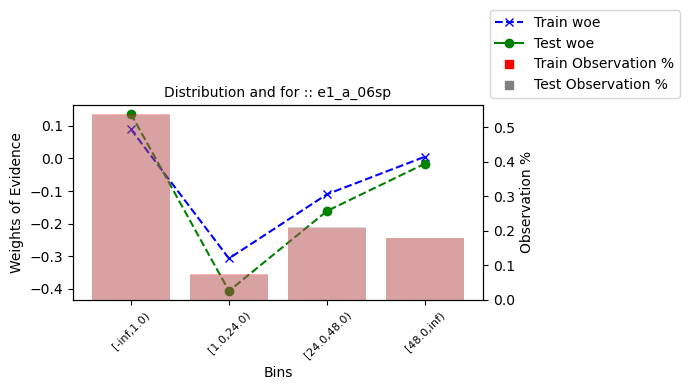

variable          bin  count  count_distr   good   bad   badprob       woe    bin_iv  total_iv breaks  is_special_values
0  e1_a_06sp   [-inf,1.0)  21593     0.538277  16818  4775  0.221136  0.089823  0.004240  0.014384    1.0              False
1  e1_a_06sp   [1.0,24.0)   2974     0.074137   2091   883  0.296907 -0.307161  0.007545  0.014384   24.0              False
2  e1_a_06sp  [24.0,48.0)   8387     0.209074   6228  2159  0.257422 -0.109823  0.002594  0.014384   48.0              False
3  e1_a_06sp   [48.0,inf)   7161     0.178512   5471  1690  0.236001  0.005500  0.000005  0.014384    inf              False

In [197]:
# Define the features and target variable
features = ['sp_f3_34','sp_g_38','sp_f3_36','e1_b_07sp','sp_b2_18','e1_a_06sp']
target = 'gb_flag'
dt = train[features + [target]]
dt1 = test[features + [target]]

# original binning breaks list
breaks_list_new = {
      'sp_f3_34':[0.0,50,75,85,90.0,95.0,97.0,100,9999],
      'sp_g_38':[42,48,54,60,72,84,96],
      'sp_f3_36':[-1,20,50,70,90,250,9999],
      'e1_b_07sp':['0','U','1%,%2%,%3%,%4%,%5%,%6'],
      'sp_b2_18':[50,75,90,100,115,125,190,9997],
      'e1_a_06sp':[-1,0,1,24,48]
    }

# Recalculate your bins and replot
train_bins_new = sc.woebin(dt, y=target, breaks_list=breaks_list_new)
test_bins_new = sc.woebin(dt1, y=target, breaks_list=breaks_list_new)

update_bins(train_bins_new)
update_bins(test_bins_new)

plot_woe(train_bins_new, test_bins_new, 'e1_a_06sp')
train_bins_new['e1_a_06sp']

In [198]:
# converting into woe transformed values
train_woe = sc.woebin_ply(dt, train_bins_new)
test_woe = sc.woebin_ply(dt1, test_bins_new)

y_train_woe = train_woe.loc[:,target]
X_train_woe = train_woe.loc[:,train_woe.columns != target]
y_test_woe = test_woe.loc[:,target]
X_test_woe = test_woe.loc[:,train_woe.columns != target]

# create logistic regression instance
# fit the model to the train data
# generate predicted values
from sklearn.linear_model import LogisticRegression
# lr = LogisticRegression(penalty='l1', C=0.9, solver='saga', n_jobs=-1)
lr = LogisticRegression()
lr.fit(X_train_woe, y_train_woe)

train_pred = lr.predict_proba(X_train_woe)[:,1]
test_pred = lr.predict_proba(X_test_woe)[:,1]

fpr_train, tpr_train, thresholds_train = roc_curve(y_train_woe, train_pred)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test_woe, test_pred)

auc_train = roc_auc_score(y_train_woe, train_pred)
auc_test = roc_auc_score(y_test_woe, test_pred)

gini_train = (2 * auc_train - 1)*100
gini_test = (2 * auc_test - 1)*100

print('---- Gini comparison ----')
print('Gini: %.2f' % gini_train)
print('Test Gini: %.2f' % gini_test)
print('Gini var: %.2f' % (100*abs(gini_train - gini_test) / gini_train))
print('---- End ----')

[INFO] converting into woe values ...
[INFO] converting into woe values ...
---- Gini comparison ----
Gini: 34.50
Test Gini: 35.39
Gini var: 2.57
---- End ----


In [199]:
X_train_woe[:].corr()

sp_g_38_woe  sp_f3_36_woe  e1_b_07sp_woe  sp_f3_34_woe  sp_b2_18_woe  e1_a_06sp_woe
sp_g_38_woe       1.000000      0.168793       0.005578      0.030973      0.058330      -0.115732
sp_f3_36_woe      0.168793      1.000000       0.118003      0.316638      0.094947       0.045058
e1_b_07sp_woe     0.005578      0.118003       1.000000      0.162606     -0.023075       0.104494
sp_f3_34_woe      0.030973      0.316638       0.162606      1.000000      0.248744      -0.002943
sp_b2_18_woe      0.058330      0.094947      -0.023075      0.248744      1.000000       0.013314
e1_a_06sp_woe    -0.115732      0.045058       0.104494     -0.002943      0.013314       1.000000

In [200]:
# run a different model type to get nicer outputs - results are the same
logit_model = sm.Logit(y_train_woe, sm.add_constant(X_train_woe))
sm_result = logit_model.fit()

# Get the p-values for each predictor variable
sm_result.summary2()

Optimization terminated successfully.
         Current function value: 0.512152
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.065     
Dependent Variable: gb_flag          AIC:              41103.9436
Date:               2023-08-15 14:26 BIC:              41164.1402
No. Observations:   40115            Log-Likelihood:   -20545.   
Df Model:           6                LL-Null:          -21967.   
Df Residuals:       40108            LLR p-value:      0.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
const            -1.1708   0.0123 -94.8882 0.0000 -1.1950 -1.1466
sp_g_38_woe      -0.9944   0.0411 -24.2073 0.0000 -1.0749 -0.9138
sp_f3_36_woe     -0.3868   0.0395  -9.7942 0.0000 -0.4642 -0.3094
e1_b_07sp_woe    -0.7551   0.0451 -16.7603 0.0000 -0.8434 -0.6668
sp_f3_34_woe     -0.7837   0.0295 -26.5260 0.0000 -0.8416 -0.7258
sp_b2_18_woe     -0.6172   0.0524 -11.7801 0.0000 -0.7199 -0.5145
e1_a_06sp_woe    -1.1559   0.1010 -11.4420 0.0000 -1.3539 -0.9579
=================================================================

"""

In [202]:
result_miv = calculate_miv_exp_woe()

print('The variable with highest MIV is:',next(iter(result_miv)),'// with MIV of:', result_miv[next(iter(result_miv))])
print()
print("\n".join(f"{key}: {value}" for key, value in list(result_miv.items())[0:50]))

The variable with highest MIV is: Score2_woe // with MIV of: {'TotIV': 0.2302487562897894, 'TotMIV': 0.11890327731494588}

Score2_woe: {'TotIV': 0.2302487562897894, 'TotMIV': 0.11890327731494588}
e5_s_05_2_all_woe: {'TotIV': 0.2302487562897894, 'TotMIV': 0.11890327731494588}
nd_sp_ciisp_woe: {'TotIV': 0.23653465060353318, 'TotMIV': 0.10892396799844586}
Score1_woe: {'TotIV': 0.19673882244020777, 'TotMIV': 0.10624439534822692}
e5_s_05_1_all_woe: {'TotIV': 0.19673882244020777, 'TotMIV': 0.10624439534822692}
e1_b_08sp_woe: {'TotIV': 0.09269175390693002, 'TotMIV': 0.06920642724692347}
sp_a_08_woe: {'TotIV': 0.09280683275397118, 'TotMIV': 0.06850694291542259}
e4_q_17sp_woe: {'TotIV': 0.0785544043899635, 'TotMIV': 0.05794364452385155}
nd_hac_02sp_woe: {'TotIV': 0.08070906465774771, 'TotMIV': 0.05734544212557766}
e1_b_12sp_woe: {'TotIV': 0.07840772294786998, 'TotMIV': 0.05666061311827021}
nd_hac_04sp_woe: {'TotIV': 0.08050605308874703, 'TotMIV': 0.0564935765362744}
e1_c_01sp_woe: {'TotIV': 0.0

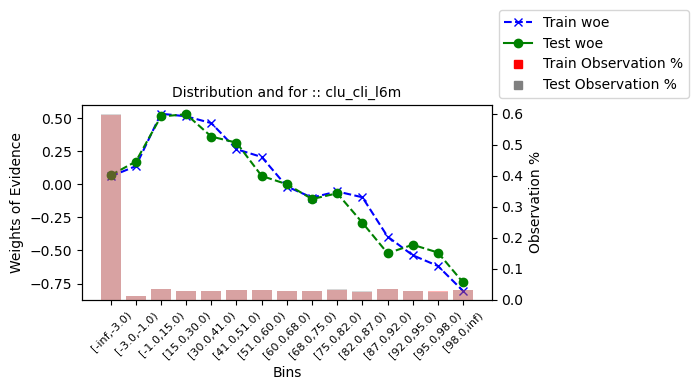

variable          bin  count  count_distr   good   bad   badprob       woe    bin_iv  total_iv breaks  is_special_values
0   clu_cli_l6m  [-inf,-3.0)  23970     0.597532  18541  5429  0.226491  0.058996  0.002047  0.078977   -3.0              False
1   clu_cli_l6m  [-3.0,-1.0)    455     0.011342    358    97  0.213187  0.136589  0.000204  0.078977   -1.0              False
2   clu_cli_l6m  [-1.0,15.0)   1426     0.035548   1206   220  0.154278  0.532204  0.008654  0.078977   15.0              False
3   clu_cli_l6m  [15.0,30.0)   1199     0.029889   1011   188  0.156797  0.513020  0.006800  0.078977   30.0              False
4   clu_cli_l6m  [30.0,41.0)   1130     0.028169    945   185  0.163717  0.461596  0.005269  0.078977   41.0              False
5   clu_cli_l6m  [41.0,51.0)   1205     0.030039    973   232  0.192531  0.264414  0.001953  0.078977   51.0              False
6   clu_cli_l6m  [51.0,60.0)   1239     0.030886    989   250  0.201776  0.206000  0.001239  0.078977   60.0              False
7   clu_cli_l6m  [60.0,68.0)   1187     0.029590    902   285  0.240101 -0.017108  0.000009  0.078977   68.0              False
8   clu_cli_l6m  [68.0,75.0)   1111     0.027695    827   284  0.255626 -0.100403  0.000287  0.078977   75.0              False
9   clu_cli_l6m  [75.0,82.0)   1239     0.030886    933   306  0.246973 -0.054413  0.000093  0.078977   82.0              False
10  clu_cli_l6m  [82.0,87.0)   1011     0.025203    753   258  0.255193 -0.098127  0.000249  0.078977   87.0              False
11  clu_cli_l6m  [87.0,92.0)   1372     0.034202    939   433  0.315598 -0.395155  0.005875  0.078977   92.0              False
12  clu_cli_l6m  [92.0,95.0)   1168     0.029116    763   405  0.346747 -0.535862  0.009470  0.078977   95.0              False
13  clu_cli_l6m  [95.0,98.0)   1125     0.028044    714   411  0.365333 -0.616943  0.012280  0.078977   98.0              False
14  clu_cli_l6m   [98.0,inf)   1278     0.031858    754   524  0.410016 -0.805332  0.024549  0.078977    inf              False

In [204]:
plot_woe(train_bins, test_bins, 'clu_cli_l6m', metric='woe')
train_bins['clu_cli_l6m']

[INFO] creating woe binning ...
[INFO] creating woe binning ...


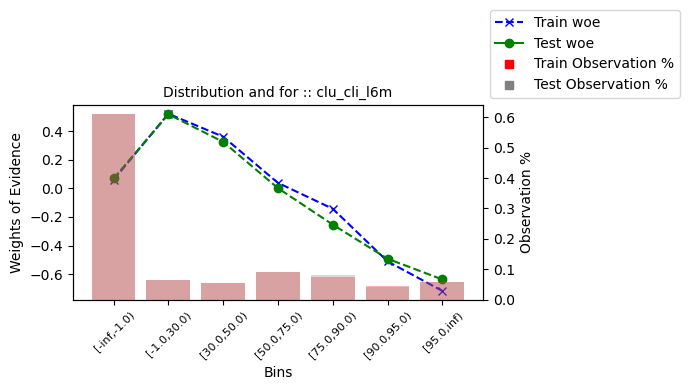

variable          bin  count  count_distr   good   bad   badprob       woe    bin_iv  total_iv breaks  is_special_values
0  clu_cli_l6m  [-inf,-1.0)  24425     0.608874  18899  5526  0.226244  0.060412  0.002187  0.075181   -1.0              False
1  clu_cli_l6m  [-1.0,30.0)   2625     0.065437   2217   408  0.155429  0.523410  0.015449  0.075181   30.0              False
2  clu_cli_l6m  [30.0,50.0)   2194     0.054693   1804   390  0.177758  0.362382  0.006493  0.075181   50.0              False
3  clu_cli_l6m  [50.0,75.0)   3678     0.091686   2832   846  0.230016  0.038986  0.000138  0.075181   75.0              False
4  clu_cli_l6m  [75.0,90.0)   2996     0.074685   2206   790  0.263685 -0.142330  0.001569  0.075181   90.0              False
5  clu_cli_l6m  [90.0,95.0)   1794     0.044721   1182   612  0.341137 -0.511002  0.013162  0.075181   95.0              False
6  clu_cli_l6m   [95.0,inf)   2403     0.059903   1468   935  0.389097 -0.718123  0.036184  0.075181    inf              False

In [206]:
# Define the features and target variable
features = ['sp_f3_34','sp_g_38','sp_f3_36','e1_b_07sp','sp_b2_18','e1_a_06sp','clu_cli_l6m']
target = 'gb_flag'
dt = train[features + [target]]
dt1 = test[features + [target]]

# original binning breaks list
breaks_list_new = {
      'sp_f3_34':[0.0,50,75,85,90.0,95.0,97.0,100,9999],
      'sp_g_38':[42,48,54,60,72,84,96],
      'sp_f3_36':[-1,20,50,70,90,250,9999],
      'e1_b_07sp':['0','U','1%,%2%,%3%,%4%,%5%,%6'],
      'sp_b2_18':[50,75,90,100,115,125,190,9997],
      'e1_a_06sp':[-1,0,1,24,48],
      'clu_cli_l6m':[-1,30,50,75,90,95]
    }

# Recalculate your bins and replot
train_bins_new = sc.woebin(dt, y=target, breaks_list=breaks_list_new)
test_bins_new = sc.woebin(dt1, y=target, breaks_list=breaks_list_new)

update_bins(train_bins_new)
update_bins(test_bins_new)

plot_woe(train_bins_new, test_bins_new, 'clu_cli_l6m')
train_bins_new['clu_cli_l6m']

In [207]:
# converting into woe transformed values
train_woe = sc.woebin_ply(dt, train_bins_new)
test_woe = sc.woebin_ply(dt1, test_bins_new)

y_train_woe = train_woe.loc[:,target]
X_train_woe = train_woe.loc[:,train_woe.columns != target]
y_test_woe = test_woe.loc[:,target]
X_test_woe = test_woe.loc[:,train_woe.columns != target]

# create logistic regression instance
# fit the model to the train data
# generate predicted values
from sklearn.linear_model import LogisticRegression
# lr = LogisticRegression(penalty='l1', C=0.9, solver='saga', n_jobs=-1)
lr = LogisticRegression()
lr.fit(X_train_woe, y_train_woe)

train_pred = lr.predict_proba(X_train_woe)[:,1]
test_pred = lr.predict_proba(X_test_woe)[:,1]

fpr_train, tpr_train, thresholds_train = roc_curve(y_train_woe, train_pred)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test_woe, test_pred)

auc_train = roc_auc_score(y_train_woe, train_pred)
auc_test = roc_auc_score(y_test_woe, test_pred)

gini_train = (2 * auc_train - 1)*100
gini_test = (2 * auc_test - 1)*100

print('---- Gini comparison ----')
print('Gini: %.2f' % gini_train)
print('Test Gini: %.2f' % gini_test)
print('Gini var: %.2f' % (100*abs(gini_train - gini_test) / gini_train))
print('---- End ----')

[INFO] converting into woe values ...
[INFO] converting into woe values ...
---- Gini comparison ----
Gini: 34.76
Test Gini: 35.65
Gini var: 2.56
---- End ----
